# Implémentez un modèle de scoring…


___Inspiré par le Kernel :___

https://www.kaggle.com/willkoehrsen/start-here-a-gentle-introduction

https://www.kaggle.com/danilz/merge-all-data-base-glm-vs-xgb-explained-0-763

---

Société financière qui propose des crédits à la consommation pour des personnes ayant peu ou pas du tout d'historique de prêt.


L’entreprise souhaite **développer un modèle de scoring de la probabilité de défaut de paiement du client** pour étayer la décision d'accorder ou non un prêt à un client potentiel en s’appuyant sur des sources de données variées (données comportementales, données provenant d'autres institutions financières, etc.).

De plus, les chargés de relation client ont fait remonter le fait que les clients sont de plus en plus demandeurs de **transparence** vis-à-vis des décisions d’octroi de crédit. Cette demande de transparence des clients va tout à fait dans le sens des valeurs que l’entreprise veut incarner.

Elle décide donc de développer un **dashboard interactif** pour que les chargés de relation client puissent à la fois expliquer de façon la plus transparente possible les décisions d’octroi de crédit, mais également permettre à leurs clients de disposer de leurs informations personnelles et de les explorer facilement. 

### Mission

1. Construire un modèle de scoring qui donnera une prédiction sur la probabilité de faillite d'un client de façon automatique.
2. Construire un dashboard interactif à destination des gestionnaires de la relation client permettant d'interpréter les prédictions faites par le modèle et d’améliorer la connaissance client des chargés de relation client.

Michaël, manager, incite à sélectionner un kernel Kaggle pour faciliter la préparation des données nécessaires à l’élaboration du modèle de scoring. L'idée est d'analyser ce kernel pour l'adapter aux besoins de la mission.

### Spécifications du dashboard
Michaël fourni un cahier des charges pour le dashboard interactif. Celui-ci devra a minima contenir les fonctionnalités suivantes :

- Permettre de visualiser le score et l’interprétation de ce score pour chaque client de façon intelligible pour une personne non experte en data science.
- Permettre de visualiser des informations descriptives relatives à un client (via un système de filtre).
- Permettre de comparer les informations descriptives relatives à un client à l’ensemble des clients ou à un groupe de clients similaires.

---

In [215]:
#Essential data science libraries
import pandas as pd
import seaborn as sns
import glob
import pickle
import os
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [216]:
pd.options.display.max_rows = 1000
pd.options.display.max_columns = 1000

In [217]:
#Graphing…
plt.style.use('fivethirtyeight')
plt.rcParams.update(
    {
     'xtick.labelsize':25,
     'ytick.labelsize':25,
     'axes.labelsize': 25,
     'legend.fontsize': 25,
     'axes.titlesize':45,
     'axes.titleweight':'bold',
     'axes.titleweight':'bold'
    })

## Chargement des données et Analyse exploratoire

### Data description from [Kaggle](https://www.kaggle.com/c/home-credit-default-risk/data) : 


#### application_{train|test}.csv
This is the main table, broken into two files for Train (with TARGET) and Test (without TARGET).
Static data for all applications. One row represents one loan in our data sample.

#### bureau.csv
All client's previous credits provided by other financial institutions that were reported to Credit Bureau (for clients who have a loan in our sample).
For every loan in our sample, there are as many rows as number of credits the client had in Credit Bureau before the application date.

#### bureau_balance.csv
Monthly balances of previous credits in Credit Bureau.
This table has one row for each month of history of every previous credit reported to Credit Bureau – i.e the table has (#loans in sample * # of relative previous credits * # of months where we have some history observable for the previous credits) rows.

#### POS_CASH_balance.csv
Monthly balance snapshots of previous POS (point of sales) and cash loans that the applicant had with Home Credit.
This table has one row for each month of history of every previous credit in Home Credit (consumer credit and cash loans) related to loans in our sample – i.e. the table has (#loans in sample * # of relative previous credits * # of months in which we have some history observable for the previous credits) rows.

#### credit_card_balance.csv
Monthly balance snapshots of previous credit cards that the applicant has with Home Credit.
This table has one row for each month of history of every previous credit in Home Credit (consumer credit and cash loans) related to loans in our sample – i.e. the table has (#loans in sample * # of relative previous credit cards * # of months where we have some history observable for the previous credit card) rows.

#### previous_application.csv
All previous applications for Home Credit loans of clients who have loans in our sample.
There is one row for each previous application related to loans in our data sample.

#### installments_payments.csv
Repayment history for the previously disbursed credits in Home Credit related to the loans in our sample.
There is a) one row for every payment that was made plus b) one row each for missed payment.
One row is equivalent to one payment of one installment OR one installment corresponding to one payment of one previous Home Credit credit related to loans in our sample.

#### HomeCredit_columns_description.csv
This file contains descriptions for the columns in the various data files.

In [218]:
%%time 
application_train = pd.read_csv('application_train.csv')
application_test = pd.read_csv('application_test.csv')
bureau = pd.read_csv('bureau.csv')
bureau_balance = pd.read_csv('bureau_balance.csv')
credit_card_balance = pd.read_csv('credit_card_balance.csv')
installments_payments = pd.read_csv('installments_payments.csv')
POS_CASH_balance = pd.read_csv('POS_CASH_balance.csv')
previous_application = pd.read_csv('previous_application.csv')
sample_submission = pd.read_csv('sample_submission.csv')

CPU times: user 24.7 s, sys: 6.3 s, total: 31 s
Wall time: 33.6 s


In [219]:
print("DOCUMENTATION :")
pd.set_option("max_colwidth", 400)
description = pd.read_csv('HomeCredit_columns_description.csv',  encoding="ISO-8859-1")
description

DOCUMENTATION :


,Unnamed: 0,Table,Row,Description,Special
0,1,application_{train|test}.csv,SK_ID_CURR,ID of loan in our sample,NaN
1,2,application_{train|test}.csv,TARGET,"Target variable (1 - client with payment difficulties: he/she had late payment more than X days on at least one of the first Y installments of the loan in our sample, 0 - all other cases)",NaN
2,5,application_{train|test}.csv,NAME_CONTRACT_TYPE,Identification if loan is cash or revolving,NaN
3,6,application_{train|test}.csv,CODE_GENDER,Gender of the client,NaN
4,7,application_{train|test}.csv,FLAG_OWN_CAR,Flag if the client owns a car,NaN
5,8,application_{train|test}.csv,FLAG_OWN_REALTY,Flag if client owns a house or flat,NaN
6,9,application_{train|test}.csv,CNT_CHILDREN,Number of children the client has,NaN
7,10,application_{train|test}.csv,AMT_INCOME_TOTAL,Income of the client,NaN
8,11,application_{train|test}.csv,AMT_CREDIT,Credit amount of the loan,NaN
9,12,application_{train|test}.csv,AMT_ANNUITY,Loan annuity,NaN


In [220]:
def data_describe(folder):
    '''Check the number of rows, columns, missing values and duplicates.
       Count type of columns.
       Memory indication'''

    data_dict = {}
    for file in folder:
        data = pd.read_csv(file)
        data_dict[file] = [data.shape[0], 
                           data.shape[1],
                            round(data.isna().sum().sum()/data.size*100, 2),
                            round(data.duplicated().sum().sum()/data.size*100, 2),
                            data.select_dtypes(include=['object']).shape[1],
                            data.select_dtypes(include=['float']).shape[1],
                            data.select_dtypes(include=['int']).shape[1],
                            data.select_dtypes(include=['bool']).shape[1],
                            round(data.memory_usage().sum()/1024**2, 3)]

        comparative_table = pd.DataFrame.from_dict(data = data_dict, 
                                                   columns = ['Rows', 'Columns', '%NaN', '%Duplicate', 
                                                              'object_dtype','float_dtype', 'int_dtype', 
                                                              'bool_dtype', 'MB_Memory'], 
                                                   orient='index')
    print("SUMMARY FILES…")
    return(comparative_table)

In [221]:
def features(folder):
    '''Comparative data with missing values, 
       and many descriptive statistics.'''
    
    data_object = {}
    data_numeric = {}
    
    for file in folder:
        data = pd.read_csv(file)
        
        data_object[file] = [(x, data[x].dtype, 
                              data[x].isna().sum().sum(),
                              int(data[x].count())) for x in data.select_dtypes(exclude=['int', 'float'])]
        
        data_numeric[file] = [(x, data[x].dtype, 
                               int(data[x].isna().sum().sum()), 
                               int(data[x].count()), 
                               int(data[x].mean()), 
                               round(data[x].std(),1),
                               round(data[x].min(),1), 
                               round(data[x].max(),1)) for x in data.select_dtypes(exclude='object')]
        

    comparative_object = pd.DataFrame.from_dict(data = data_object, orient='index')
    dict_of_object = {name: pd.DataFrame(file) for name,file in data_object.items()}
    df1 = pd.concat(dict_of_object, axis=0)
    df1.columns=['features','dtype','nan','count']
    
    comparative_numeric = pd.DataFrame.from_dict(data = data_numeric, orient='index')
    dict_of_numeric = {name: pd.DataFrame(file) for name,file in data_numeric.items()}
    df2 = pd.concat(dict_of_numeric, axis=0)
    df2.columns=['features','dtype','nan','count', 'mean', 'std', 'min','max']
        
    return df1, df2

### EDA application_train.csv | test.csv
La première partie permet d'illustrer globalement les données disponibles. Il est nécessaire d'approfondir l'analyse des features du ou des principaux fichiers.

In [222]:
print('Training Features shape: ', application_train.shape)
print('Testing Features shape: ', application_test.shape)

Training Features shape:  (307511, 122)
Testing Features shape:  (48744, 121)


In [223]:
#Distribution of the Target Column
application_train['TARGET'].value_counts()

0    282686
1     24825
Name: TARGET, dtype: int64

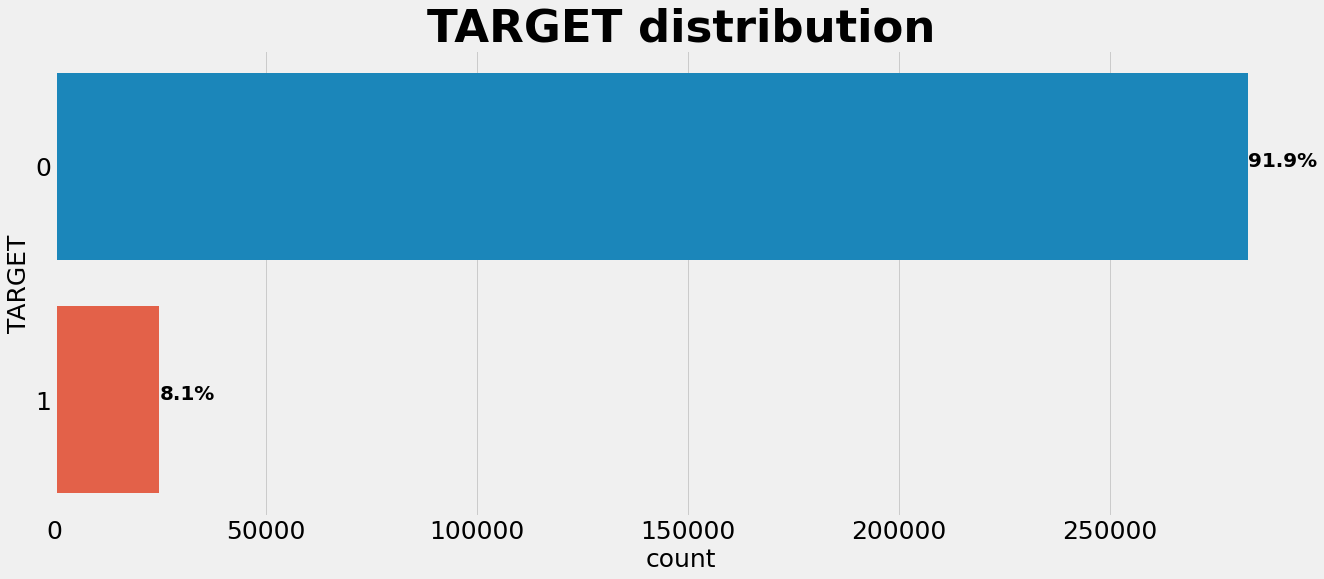

In [224]:
ax, fig = plt.subplots(figsize=(20,8)) 
ax = sns.countplot(y='TARGET', data=application_train)
ax.set_title("TARGET distribution")

for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_width()/len(application_train.TARGET))
        x = p.get_x() + p.get_width()
        y = p.get_y() + p.get_height()/2
        ax.annotate(percentage, (x, y), fontsize=20, fontweight='bold')
        
show()

Notons des classes déséquilibrées. Il y a beaucoup plus de prêts remboursés à temps que de prêts non remboursés. Une fois que nous entrons dans des modèles d'apprentissage automatique plus sophistiqués, nous pouvons pondérer les classes par leur représentation dans les données pour refléter ce déséquilibre.

### Types de colonnes
Analyse rapide du type de features, mais surtout établir un aperçu afin de pouvoir poser une réflexion sur l'encodage des données catégorielles.

In [225]:
#Number of each type of column
application_train.dtypes.value_counts()

float64    65
int64      41
object     16
dtype: int64

In [226]:
#Number of unique classes in each object column
application_train.select_dtypes('object').nunique()

NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

La plupart des variables catégorielles ont un nombre relativement petit d'entrées uniques. Nous devrons trouver un moyen de traiter ces variables catégorielles…

### Valeurs manquantes
En modélisation, des modèles tels que XGBoost peuvent gérer les valeurs manquantes sans imputation. Plusieurs alternatives seront possibles: remplacer les NaN, supprimer les colonnes avec un pourcentage élevé de valeurs manquantes (impossible de savoir à l'avance si ces colonnes seront utiles à notre modèle). Dans l'immédiat toutes les colonnes sont conservées…

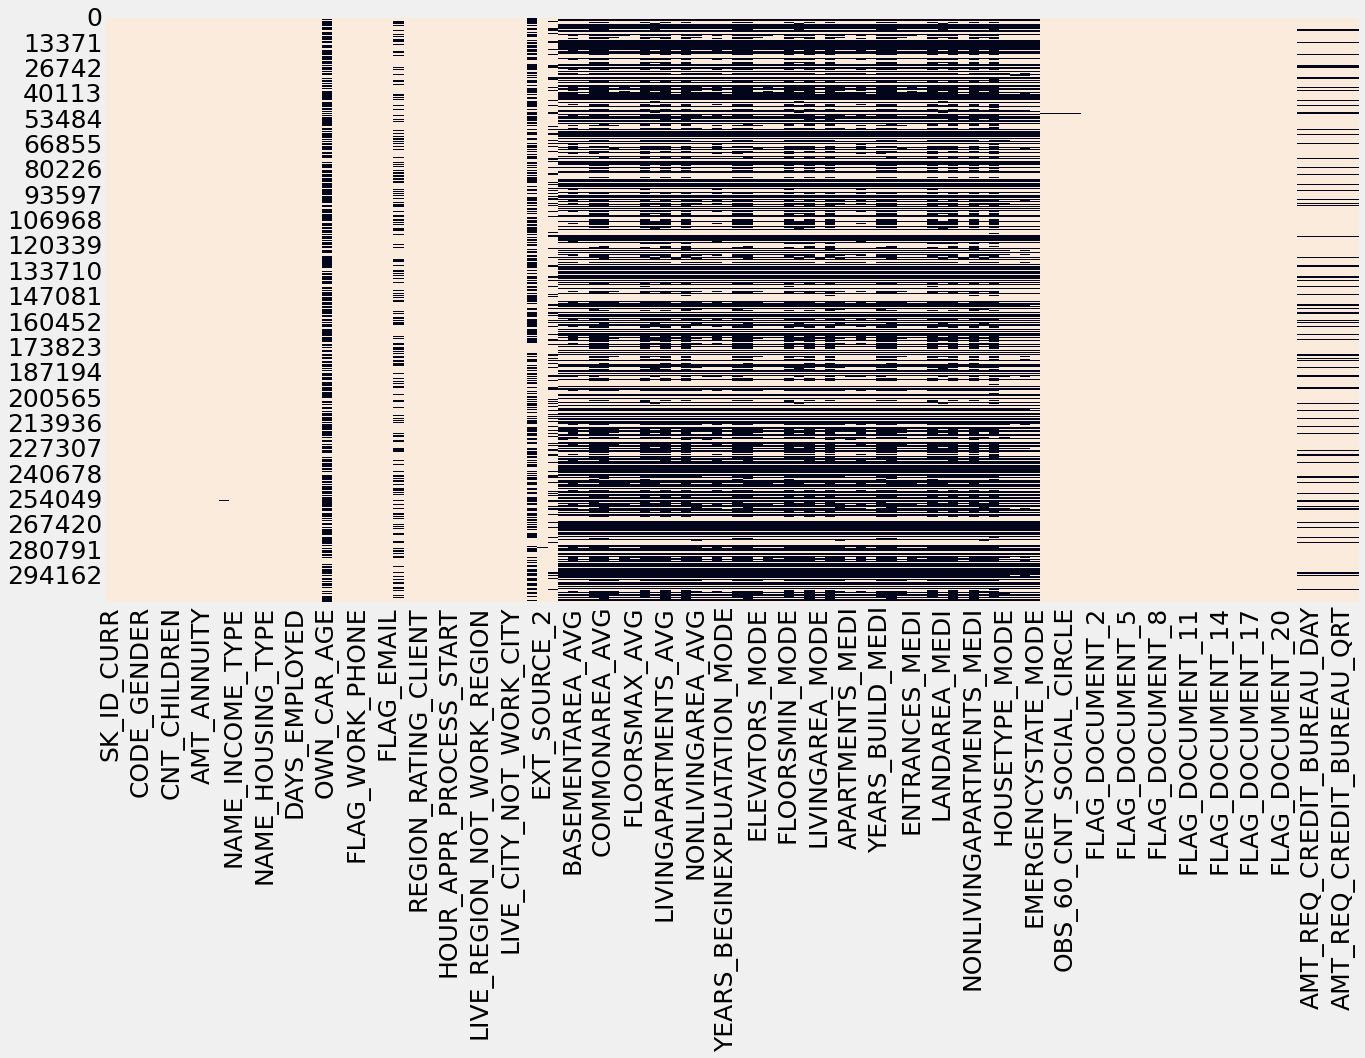

In [227]:
#Global view of the missing values (black)
plt.figure(figsize=(20,10))
sns.heatmap(application_train.notna(), cbar=False)
show()

Une synthèse des données manquantes un peu confuse du fait du grand nombre de variables, mais il se dégage un premier constat qui montre que les NaN sont plus fortement présentent sur les caractéristiques des habitats (et non sur les crédits), comme l'atteste le TOP 10 ci-après…

In [228]:
def nan_check(data):
    '''Check Missing Values'''
    total = data.isnull().sum()
    percent_1 = data.isnull().sum()/data.isnull().count()*100
    percent_2 = (np.round(percent_1, 2))
    missing_data = pd.concat([total, percent_2], 
                             axis=1, keys=['Total', '%']).sort_values('%', ascending=False)
    return missing_data

print('TOP 10 Missing values from Training dataset')
nan_check(application_train)[:10]

TOP 10 Missing values from Training dataset


,Total,%
COMMONAREA_MEDI,214865,69.87
COMMONAREA_AVG,214865,69.87
COMMONAREA_MODE,214865,69.87
NONLIVINGAPARTMENTS_MODE,213514,69.43
NONLIVINGAPARTMENTS_AVG,213514,69.43
NONLIVINGAPARTMENTS_MEDI,213514,69.43
FONDKAPREMONT_MODE,210295,68.39
LIVINGAPARTMENTS_MODE,210199,68.35
LIVINGAPARTMENTS_AVG,210199,68.35
LIVINGAPARTMENTS_MEDI,210199,68.35


In [229]:
print("Nb of columns in the training sample: " + str(len(nan_check(application_train))))

print("Nb of columns in the training sample with missing values: " + 
      str(len(nan_check(application_train)[nan_check(application_train)['Total']!=0])))

Nb of columns in the training sample: 122
Nb of columns in the training sample with missing values: 67


### Outliers, valeurs atypiques, anormales
En préambule, le constat est simple, des variables comme 'DAYS_BIRTH' ont des valeurs négatives. Il est donc important de pouvoir analyser et si besoin rectifier ce type de données.

In [230]:
#Client's age in days at the time of application (def. from HomeCredit_columns_description.csv)
application_train['DAYS_BIRTH'].describe()

count    307511.000000
mean     -16036.995067
std        4363.988632
min      -25229.000000
25%      -19682.000000
50%      -15750.000000
75%      -12413.000000
max       -7489.000000
Name: DAYS_BIRTH, dtype: float64

Les nombres de la colonne DAYS_BIRTH sont négatifs car ils sont enregistrés par rapport à la demande de prêt en cours. Il est nécessaire de modifier cette variable pour obtenir des chiffres plus compréhensibles pour l'analyse.

In [231]:
(application_train['DAYS_BIRTH'] / -365).describe()

count    307511.000000
mean         43.936973
std          11.956133
min          20.517808
25%          34.008219
50%          43.150685
75%          53.923288
max          69.120548
Name: DAYS_BIRTH, dtype: float64

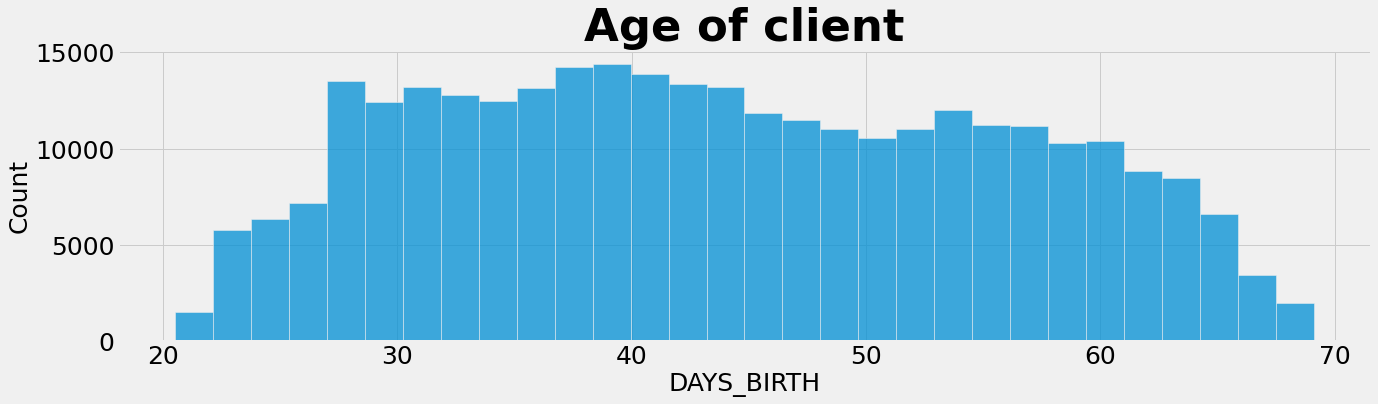

In [232]:
plt.figure(figsize=(20, 5))
sns.histplot((application_train['DAYS_BIRTH'] / -365), bins = 30).set_title('Age of client')
show()

In [233]:
#How many days before the application the perso... (def. from HomeCredit_columns_description.csv)
application_train['DAYS_EMPLOYED'].describe()

count    307511.000000
mean      63815.045904
std      141275.766519
min      -17912.000000
25%       -2760.000000
50%       -1213.000000
75%        -289.000000
max      365243.000000
Name: DAYS_EMPLOYED, dtype: float64

In [234]:
application_test['DAYS_EMPLOYED'].describe()

count     48744.000000
mean      67485.366322
std      144348.507136
min      -17463.000000
25%       -2910.000000
50%       -1293.000000
75%        -296.000000
max      365243.000000
Name: DAYS_EMPLOYED, dtype: float64

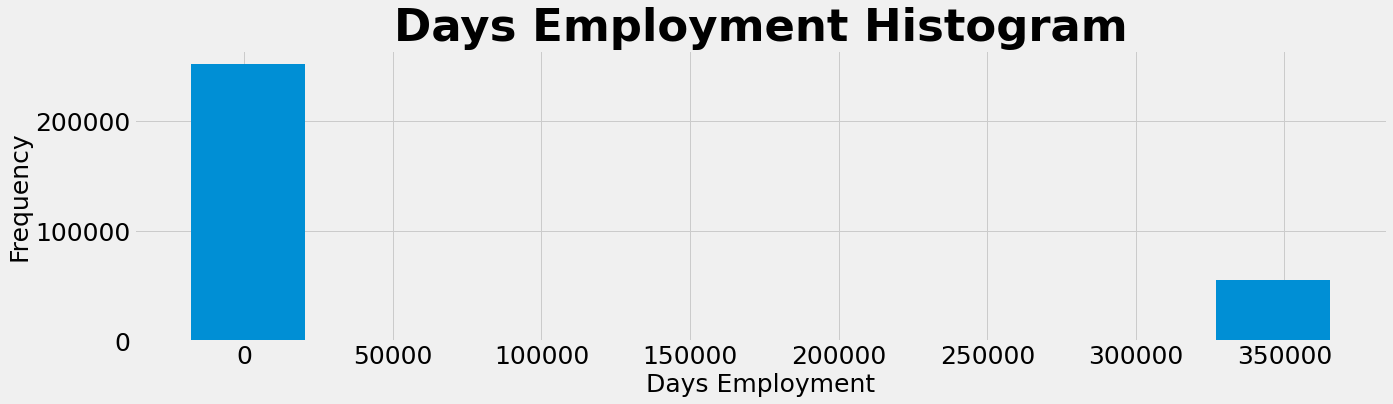

In [235]:
application_train['DAYS_EMPLOYED'].plot.hist(title = 'Days Employment Histogram', figsize=(20,5));
plt.xlabel('Days Employment')
show()

Idem ces données ne sont pas "normales" au sens où le Max. représente 1000 années (365243/365j).
Est-ce un individu isolé? Plusieurs individus de l'échantillon?

In [236]:
print("%0.0f values with 365243 days employed for training data" % 
      len(application_train[application_train['DAYS_EMPLOYED'] == 365243]))
print("%0.0f Total values from days employed for training data" % application_train.shape[0])
print("***********************")
print("%0.0f values with 365243 days employed for testing data" % 
      len(application_test[application_test['DAYS_EMPLOYED'] == 365243]))
print("%0.0f Total values from days employed for testing data" % application_test.shape[0])

55374 values with 365243 days employed for training data
307511 Total values from days employed for training data
***********************
9274 values with 365243 days employed for testing data
48744 Total values from days employed for testing data


In [237]:
#Create an outliers flag column
application_train['DAYS_EMPLOYED_OUTLIERS'] = application_train["DAYS_EMPLOYED"] == 365243
application_test['DAYS_EMPLOYED_OUTLIERS'] = application_test["DAYS_EMPLOYED"] == 365243

#Replace outliers values with nan
application_train['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)
application_test['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)

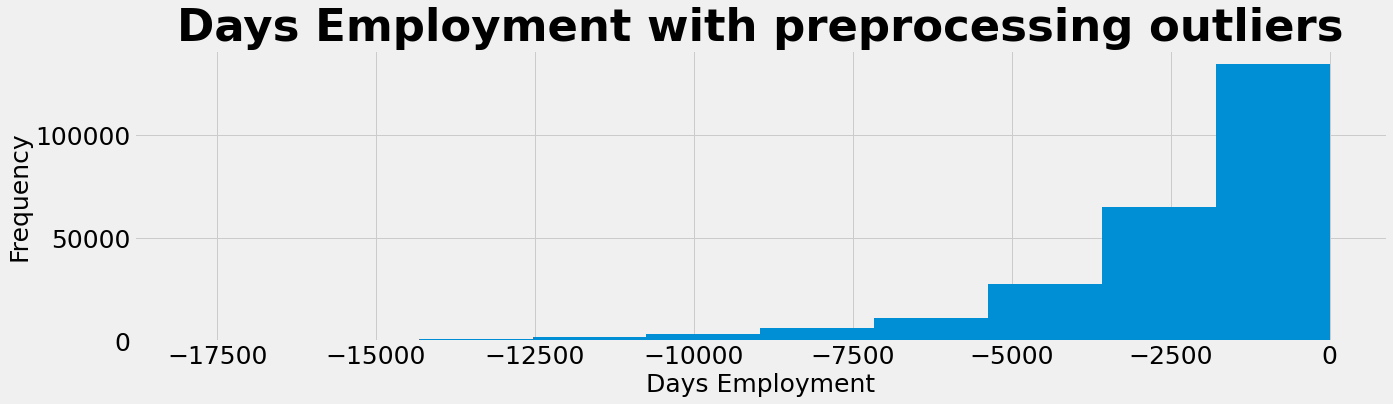

In [238]:
application_train['DAYS_EMPLOYED'].plot.hist(title ='Days Employment with preprocessing outliers', figsize=(20,5))
plt.xlabel('Days Employment')
show()

### Fonctions pour faciliter l'analyse des principales variables…
Il est important de se focaliser sur les principales features pouvant être explicatives. Ici l'idée n'est pas de tout analyser en univarié ou multivarié, mais simplement d'avoir une image des points métiers qui aident à orienter nos décisions dans la "prise de risque" à l'attribution d'un crédit.

In [239]:
def plot_stat(data, feature, title) : 
    
    ax, fig = plt.subplots(figsize=(20,8)) 
    ax = sns.countplot(y=feature, data=data, order=data[feature].value_counts(ascending=False).index)
    ax.set_title(title)

    for p in ax.patches:
                percentage = '{:.1f}%'.format(100 * p.get_width()/len(data[feature]))
                x = p.get_x() + p.get_width()
                y = p.get_y() + p.get_height()/2
                ax.annotate(percentage, (x, y), fontsize=20, fontweight='bold')

    show()

In [240]:
def plot_percent_target1(data, feature, title) : 
    
    cat_perc = data[[feature, 'TARGET']].groupby([feature],as_index=False).mean()
    cat_perc.sort_values(by='TARGET', ascending=False, inplace=True)
    
    ax, fig = plt.subplots(figsize=(20,8)) 
    ax = sns.barplot(y=feature, x='TARGET', data=cat_perc)
    ax.set_title(title)
    ax.set_xlabel("")
    ax.set_ylabel("Percent of target with value 1")

    for p in ax.patches:
                percentage = '{:.1f}%'.format(100 * p.get_width())
                x = p.get_x() + p.get_width()
                y = p.get_y() + p.get_height()/2
                ax.annotate(percentage, (x, y), fontsize=20, fontweight='bold')

    show()

**Loan types -** Distribution du type de prêts contractés + comparatif avec le pourcentage des prêts avec la valeur TARGET 1(prêt non retourné).

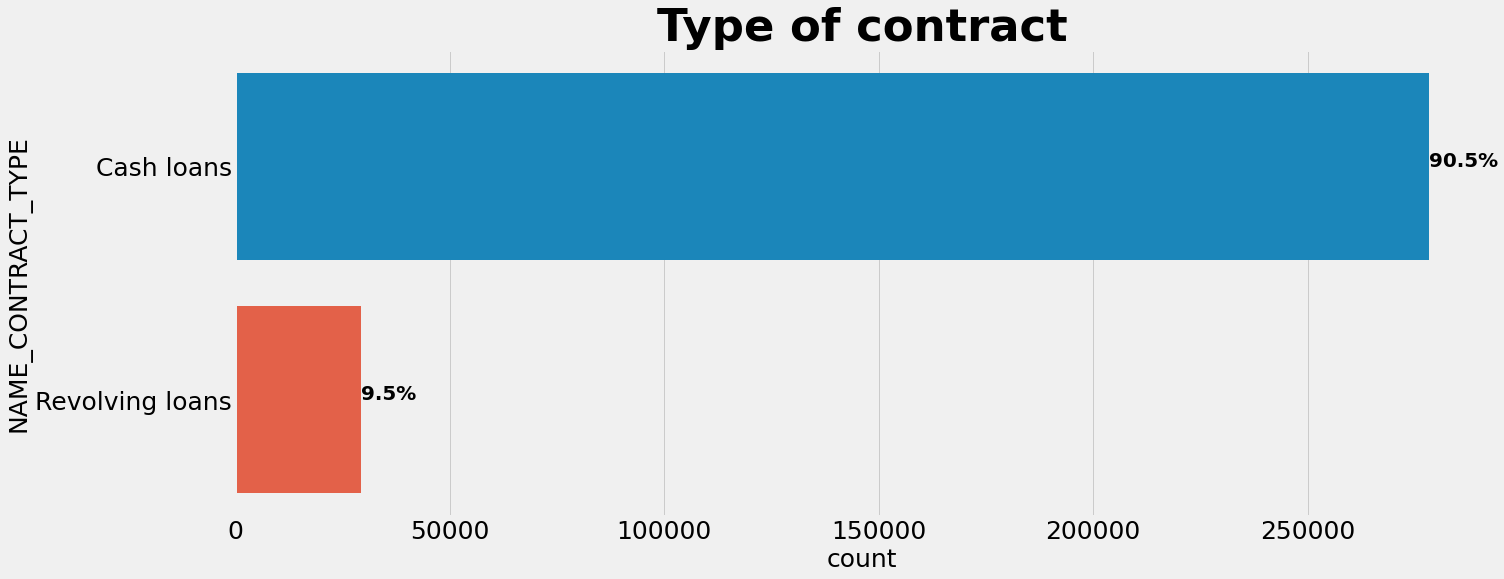

                                   -------------------------------------------------------


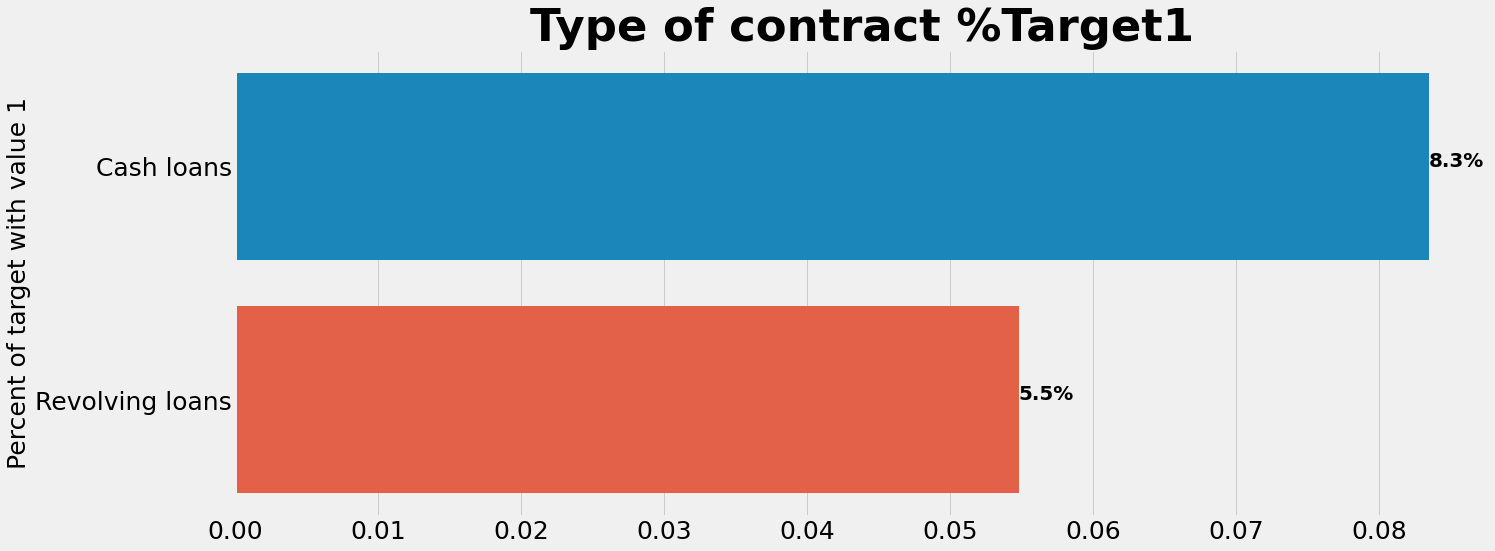

In [241]:
#NAME_CONTRACT_TYPE
plot_stat(application_train, 'NAME_CONTRACT_TYPE',"Type of contract")
print("                                   -------------------------------------------------------")
plot_percent_target1(application_train, 'NAME_CONTRACT_TYPE',"Type of contract %Target1")

Les prêts renouvelables ne représentent qu'une petite fraction (10%) du nombre total de prêts; dans le même temps, un plus grand nombre de crédits renouvelables, par rapport à leur fréquence, ne sont pas remboursés.

**Client gender -** Distribution H/F clients, mais aussi le pourcentage des prêts (par sexe du client) avec la valeur TARGET 1 (prêt non retourné).

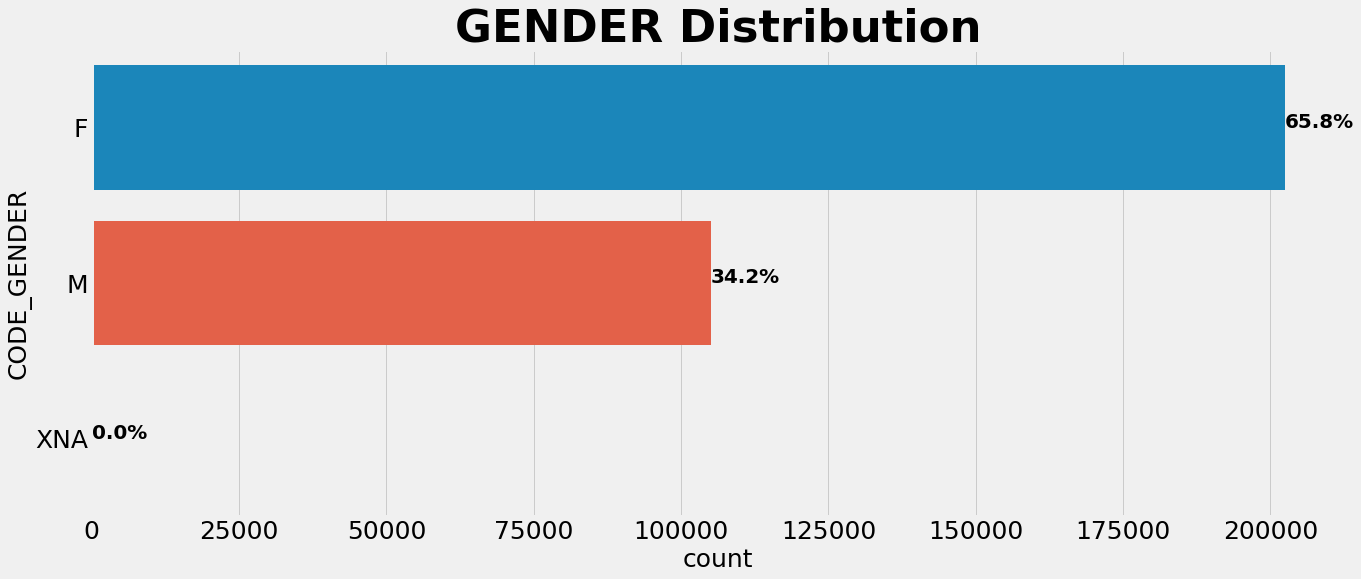

                                   -------------------------------------------------------


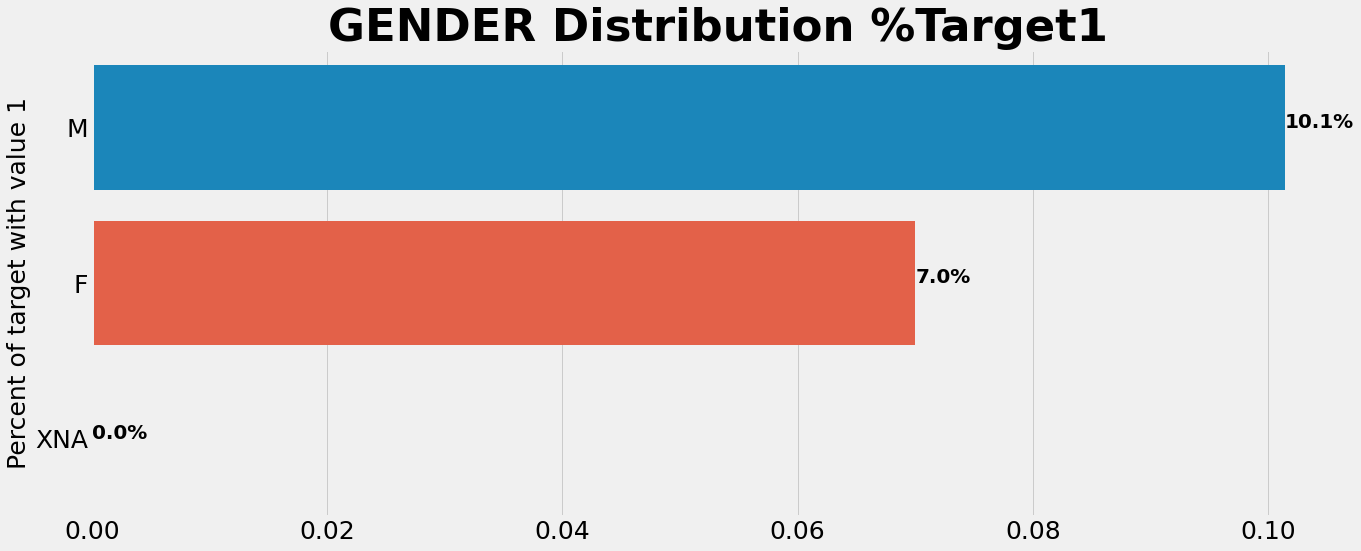

In [242]:
#CODE_GENDER
plot_stat(application_train, 'CODE_GENDER',"GENDER Distribution")
print("                                   -------------------------------------------------------")
plot_percent_target1(application_train, 'CODE_GENDER',"GENDER Distribution %Target1")

Le nombre de clients féminins est presque le double du nombre de clients masculins. En ce qui concerne le pourcentage de crédits en souffrance, les hommes ont plus de chances de ne pas rembourser leurs prêts (10%), comparativement aux femmes (7%).

**Flag own car -** Distribution d'un impact possible entre les clients propriétaire d'un véhicule et ceux qui ne le sont pas…

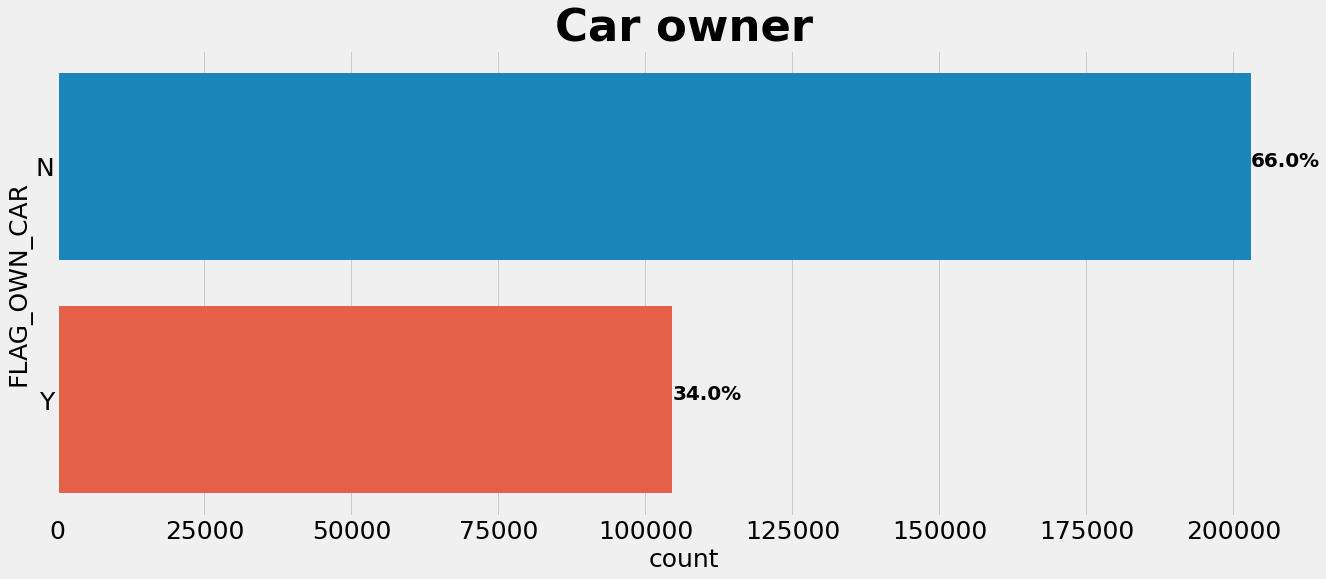

                                   -------------------------------------------------------


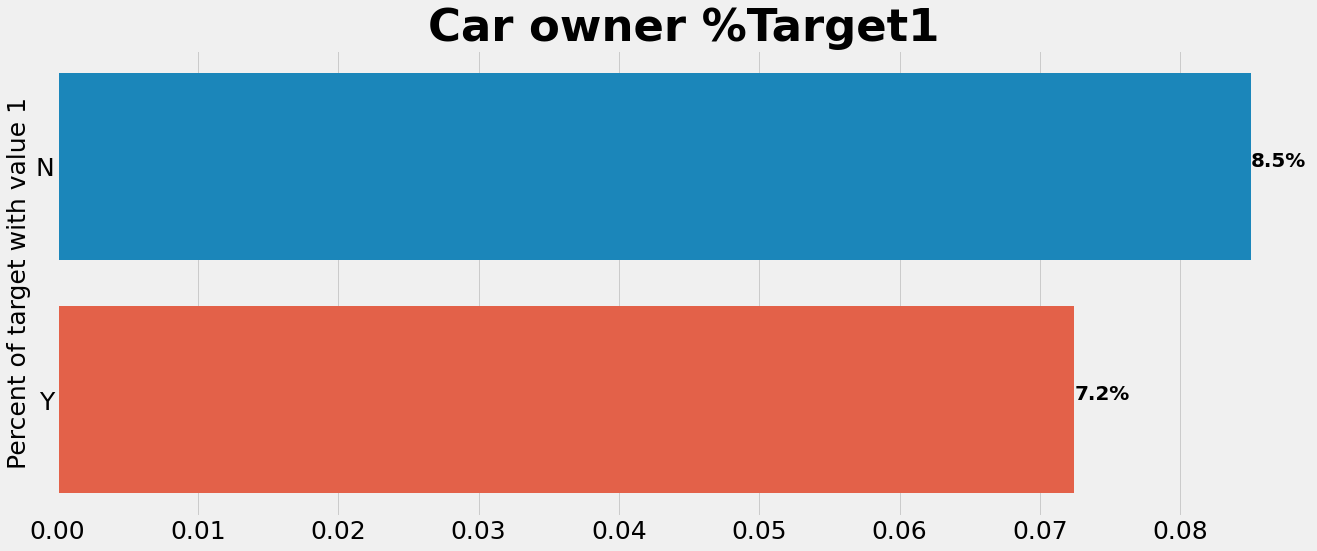

In [243]:
#FLAG_OWN_CAR
plot_stat(application_train, 'FLAG_OWN_CAR',"Car owner")
print("                                   -------------------------------------------------------")
plot_percent_target1(application_train, 'FLAG_OWN_CAR',"Car owner %Target1")

Les deux catégories (propriétaire ou non) ont des taux de non-remboursement d'environ 8%.

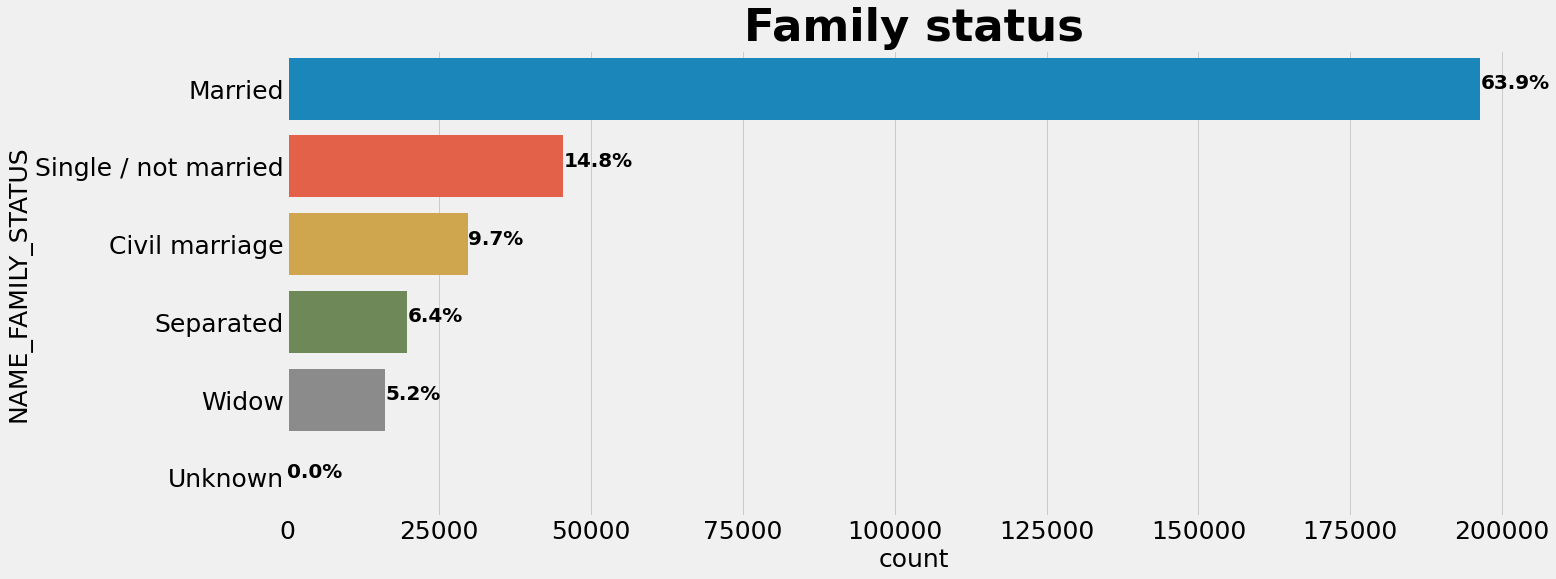

                                   -------------------------------------------------------


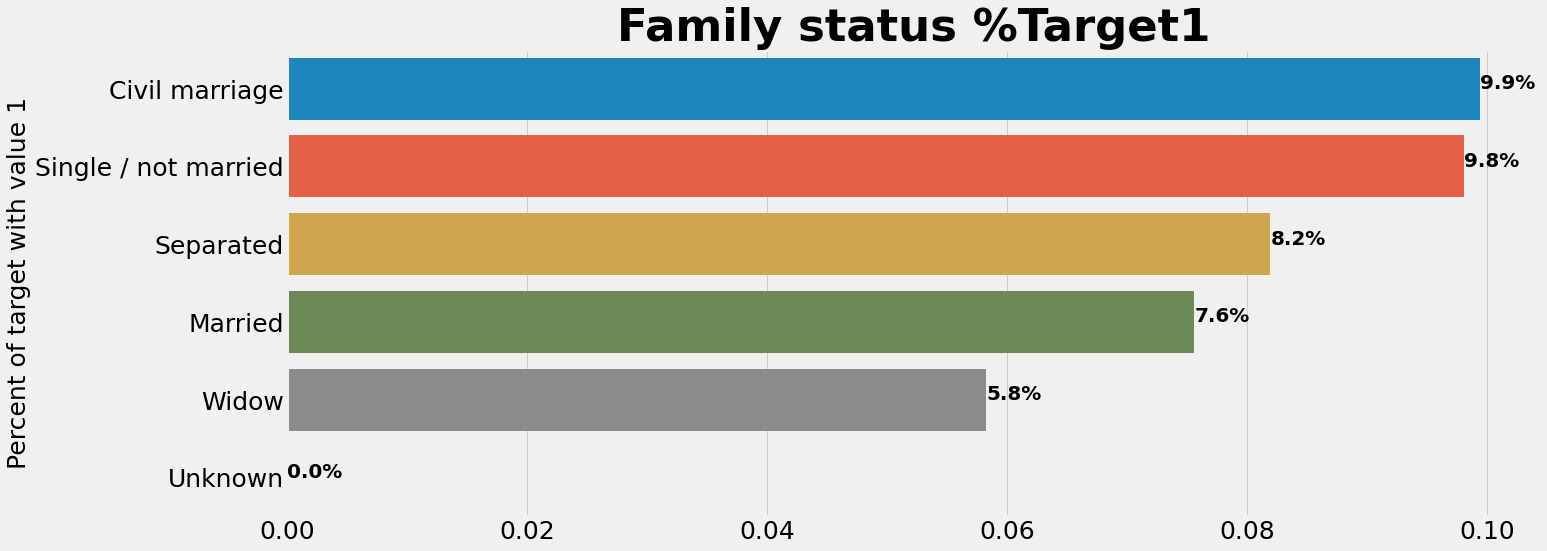

In [244]:
#NAME_FAMILY_STATUS
plot_stat(application_train, 'NAME_FAMILY_STATUS',"Family status")
print("                                   -------------------------------------------------------")
plot_percent_target1(application_train, 'NAME_FAMILY_STATUS',"Family status %Target1")

La plupart des clients sont mariés, suivis des célibataires / non mariés et des mariages civils.

En termes de pourcentage de non-remboursement du prêt, le mariage civil a le pourcentage le plus élevé de non-remboursement (10%), la veuve étant le plus bas (à l'exception de l'inconnu).

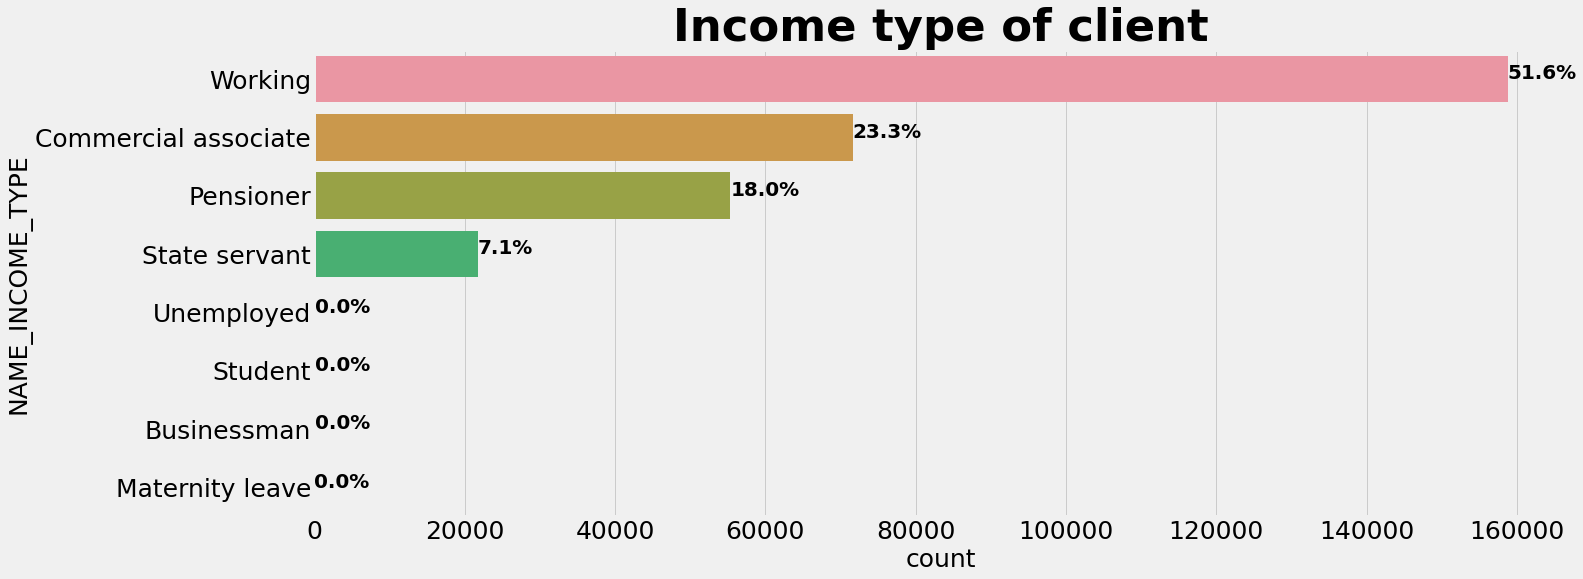

                                   -------------------------------------------------------


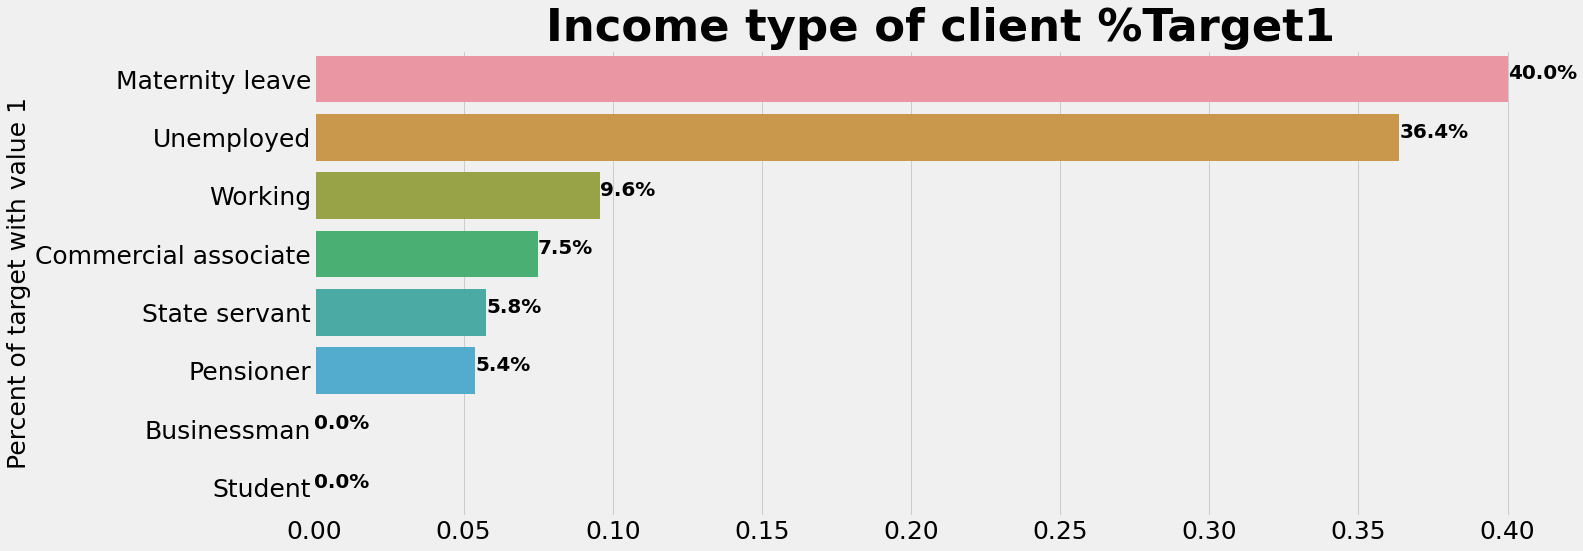

In [245]:
#NAME_INCOME_TYPE
plot_stat(application_train, 'NAME_INCOME_TYPE',"Income type of client")
print("                                   -------------------------------------------------------")
plot_percent_target1(application_train, 'NAME_INCOME_TYPE',"Income type of client %Target1")

La plupart des demandeurs de prêts sont des revenus du travail, suivis par un associé commercial, un retraité et un fonctionnaire.

Les demandeurs avec le type de revenu Congé de maternité ont un ratio de près de 40% de prêts non remboursés, suivis des chômeurs (37%). Les autres types de revenus sont inférieurs à la moyenne de 10% pour ne pas rembourser les prêts.

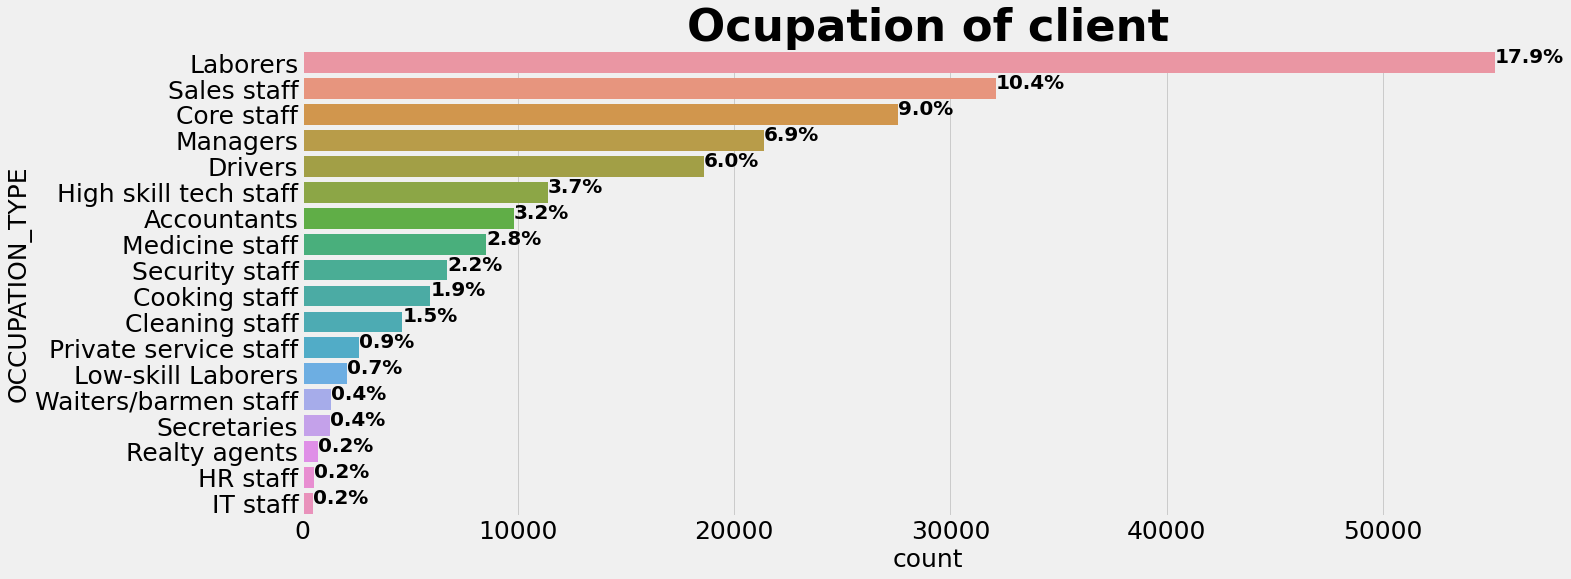

                                   -------------------------------------------------------


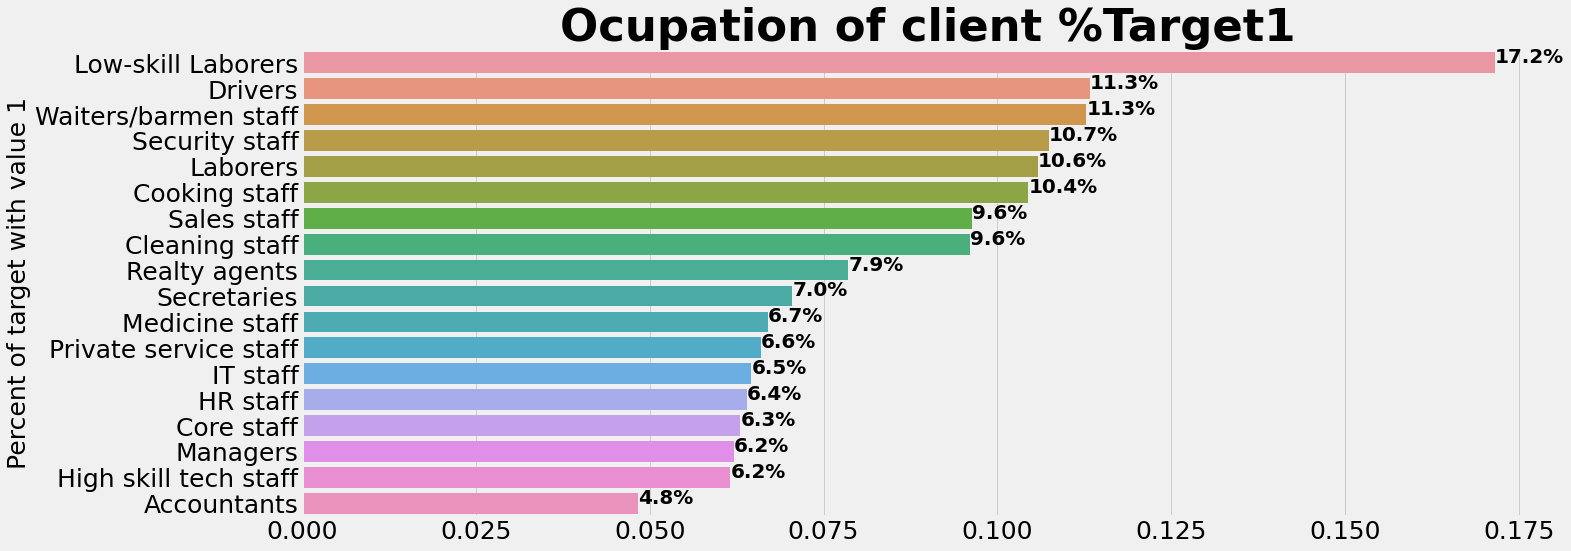

In [246]:
#OCCUPATION_TYPE
plot_stat(application_train, 'OCCUPATION_TYPE',"Ocupation of client")
print("                                   -------------------------------------------------------")
plot_percent_target1(application_train, 'OCCUPATION_TYPE',"Ocupation of client %Target1")

La plupart des prêts sont contractés par des ouvriers, suivis par les vendeurs/commerciaux. Le personnel informatique prend le montant de prêts le plus bas.

La catégorie avec le pourcentage le plus élevé de prêts non remboursés est celle des ouvriers peu qualifiés (plus de 17%), suivis des chauffeurs et des serveurs / barmen, du personnel de sécurité, des ouvriers et du personnel de cuisine.

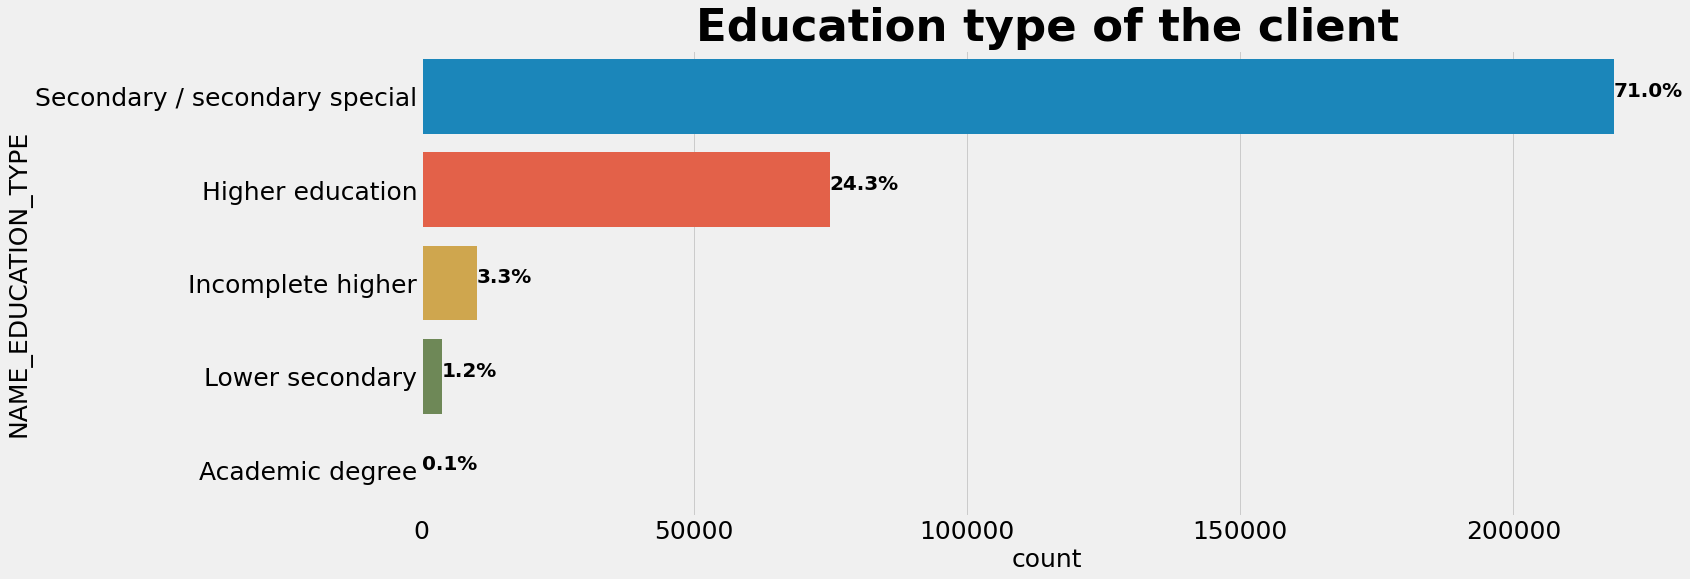

                                   -------------------------------------------------------


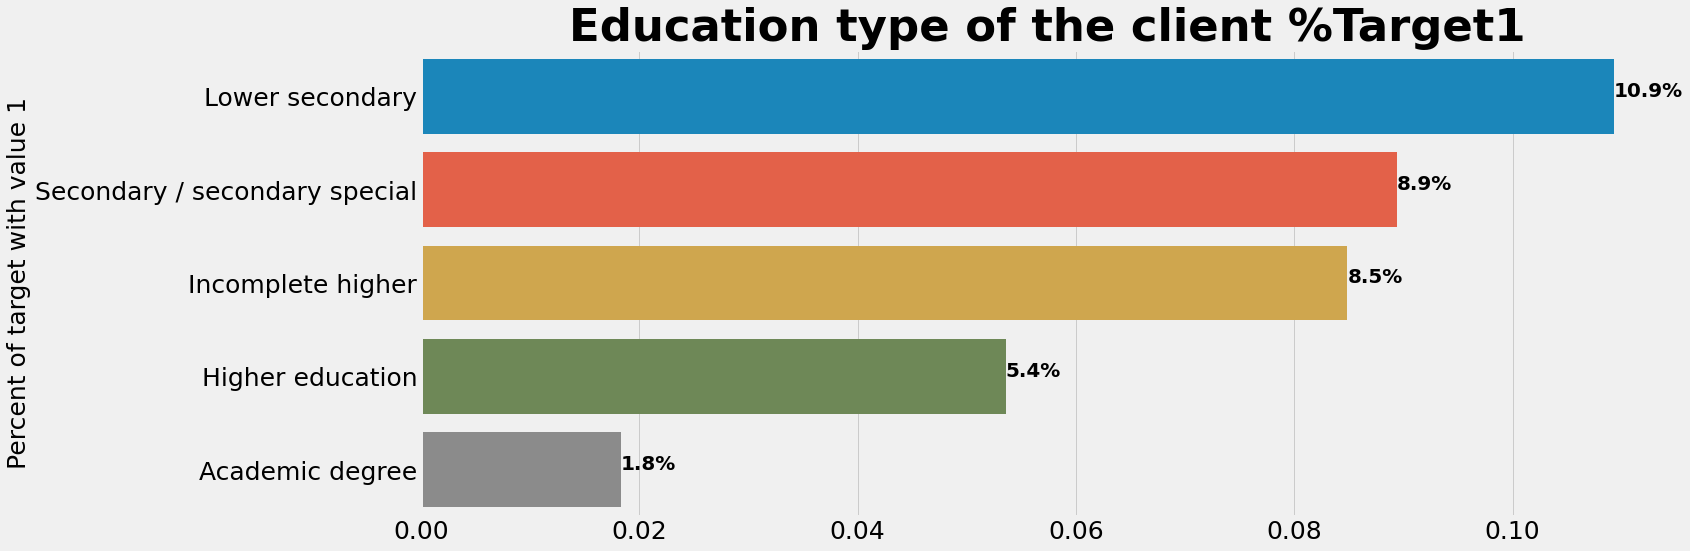

In [247]:
#NAME_EDUCATION_TYPE
plot_stat(application_train, 'NAME_EDUCATION_TYPE',"Education type of the client")
print("                                   -------------------------------------------------------")
plot_percent_target1(application_train, 'NAME_EDUCATION_TYPE',"Education type of the client %Target1")

La majorité des clients ont une éducation dans l'éducation secondaire, suivis des clients avec une éducation supérieure. Un très petit nombre d'emprunteur possède un diplôme universitaire.

La catégorie du premier cycle du secondaire, bien que rare, a le taux le plus élevé de non-remboursement du prêt (11%). Les personnes ayant un diplôme universitaire ont un taux de non-remboursement inférieur à 2%.

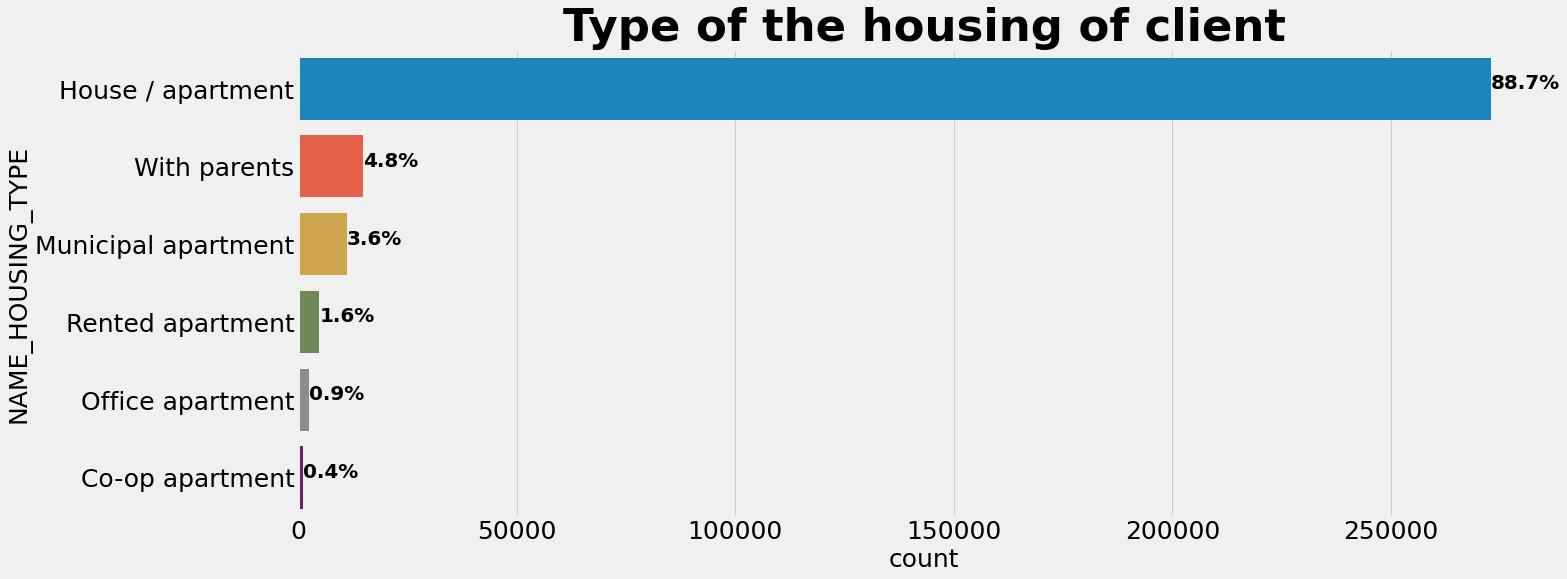

                                   -------------------------------------------------------


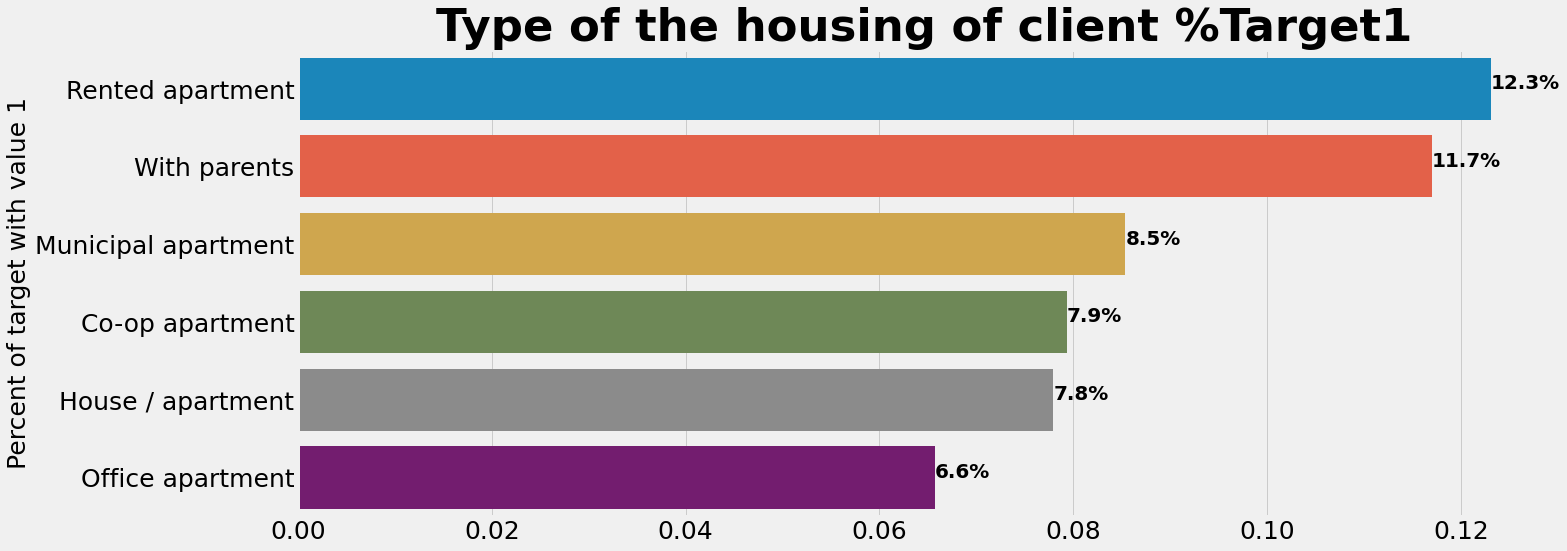

In [248]:
#NAME_HOUSING_TYPE
plot_stat(application_train, 'NAME_HOUSING_TYPE',"Type of the housing of client")
print("                                   -------------------------------------------------------")
plot_percent_target1(application_train, 'NAME_HOUSING_TYPE',"Type of the housing of client %Target1")

Plus de 250 000 demandeurs de crédits vivent en maison ou appartement. Les catégories suivantes, faible pourcentage, représentent une population moins "indépendante" (vivre chez ses parents, etc…).

Dans ces catégories, les loueurs d'appartements (non propriétaires de leur résidence principale), ainsi que ceux qui vivent chez leurs parents, ont un taux de non-remboursement supérieur à 10%.

### Corrélations
L'analyse peut continuer par une étape de traitement des corrélations entre les caractéristiques et la Target. L'idée est de calculer le coefficient de corrélation de Pearson entre chaque variable et la Target. Cette étape permet d'avoir un aperçu des relations possibles entre les variables.

In [249]:
#Display correlations
print('Most Positive Correlations:\n', application_train.corr()['TARGET'].sort_values().tail(15))
print("--------------------------")
print('Most Negative Correlations:\n', application_train.corr()['TARGET'].sort_values().head(15))

Most Positive Correlations:
 DEF_30_CNT_SOCIAL_CIRCLE       0.032248
LIVE_CITY_NOT_WORK_CITY        0.032518
OWN_CAR_AGE                    0.037612
DAYS_REGISTRATION              0.041975
FLAG_DOCUMENT_3                0.044346
REG_CITY_NOT_LIVE_CITY         0.044395
FLAG_EMP_PHONE                 0.045982
REG_CITY_NOT_WORK_CITY         0.050994
DAYS_ID_PUBLISH                0.051457
DAYS_LAST_PHONE_CHANGE         0.055218
REGION_RATING_CLIENT           0.058899
REGION_RATING_CLIENT_W_CITY    0.060893
DAYS_EMPLOYED                  0.074958
DAYS_BIRTH                     0.078239
TARGET                         1.000000
Name: TARGET, dtype: float64
--------------------------
Most Negative Correlations:
 EXT_SOURCE_3                 -0.178919
EXT_SOURCE_2                 -0.160472
EXT_SOURCE_1                 -0.155317
DAYS_EMPLOYED_OUTLIERS       -0.045987
FLOORSMAX_AVG                -0.044003
FLOORSMAX_MEDI               -0.043768
FLOORSMAX_MODE               -0.043226
AMT_GOODS_PRI

Notons que la corrélation la plus forte est celle de la variable 'DAYS_BIRTH'. Ceci étant, pour faciliter la compréhension est retrouver la logique vue en préambule, les jours exprimés en valeurs négatives peuvent être traités en valeurs absolues. Alors le coef. de Person sera négatif, cela expose le fait qu'un client plus âgé sera moins susceptible de faire défaut au remboursement de son crédit (cela peut sembler logique, en tout cas ce n'est pas absurde).

In [250]:
#Find the correlation of the positive days since birth and target
application_train['DAYS_BIRTH'] = abs(application_train['DAYS_BIRTH'])
application_train['DAYS_BIRTH'].corr(application_train['TARGET'])

-0.07823930830982737

En termes de distribution des âges elle peut uniquement servir à visualiser la non présence d'outliers, suite à ce qui a été fait en amont sur les valeurs négatives de départ. Pour visualiser l'effet de l'âge sur la Target, nous pouvons faire un graphique (KDE) coloré par la valeur TARGET 0 et 1.

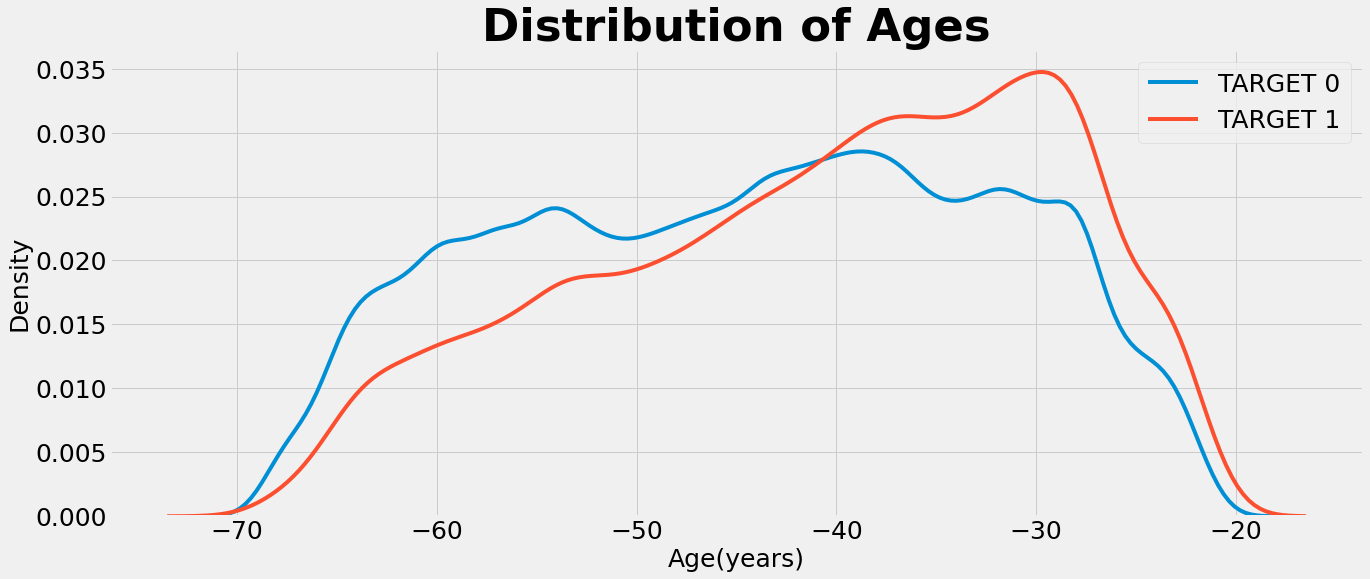

In [251]:
plt.figure(figsize = (20, 8))
sns.kdeplot(application_train[application_train['TARGET'] == 0]['DAYS_BIRTH'] / -365, label = 'TARGET 0')
sns.kdeplot(application_train[application_train['TARGET'] == 1]['DAYS_BIRTH'] / -365, label = 'TARGET 1')

plt.legend(), plt.xlabel('Age(years)'), plt.ylabel('Density'), plt.title('Distribution of Ages')
show()

La courbe cible TARGET 1 s'incline vers l'extrémité la plus jeune de la plage. Bien qu'il ne s'agisse pas d'une corrélation significative (coefficient Pearson -0,07), cette variable sera probablement utile dans un modèle d'apprentissage car elle affecte la Target.

#### Sources extérieures, les plus fortes corrélations linéaires…
Ces 3 variables (EXT_SOURCE) présentant les corrélations négatives les plus fortes avec la Target. Selon la documentation, ces fonctionnalités représentent un «score normalisé à partir d'une source de données externe». 
Difficile de comprendre le sens exact, nous pouvons émettre l'hypothèse d'une cote de crédit cumulative établie à l'aide de différentes sources de données.

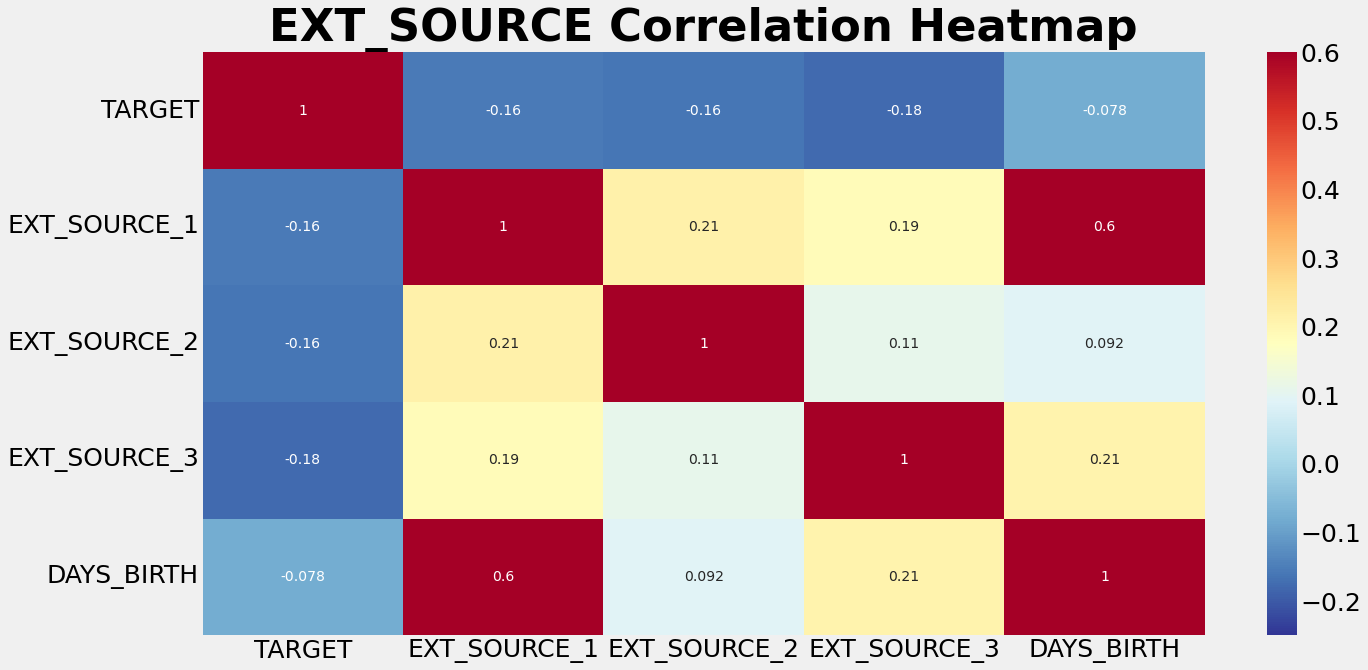

In [252]:
#Heatmap of correlations
plt.figure(figsize = (20,10))
sns.heatmap(application_train[['TARGET', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']].corr(),
            cmap = plt.cm.RdYlBu_r, vmin = -0.25, annot = True, vmax = 0.6,
           )
plt.title('EXT_SOURCE Correlation Heatmap')
show()

Ces sources extérieures sont corrélées négativement avec la Target (Attention, négativement mais avec de très faibles coefficients). Malgré tout, on peut penser que si la valeur augmente, le client est plus susceptible de pouvoir rembourser le crédit. Notons que 'DAYS_BIRTH' est corrélée avec 'EXT_SOURCE_1', peut-être l'un des facteurs de ce score est l'âge du client.

In [253]:
#Plot distribution of one feature
def plot_distribution(feature, title):
    plt.figure(figsize=(20,6))

    t0 = application_train.loc[application_train['TARGET'] == 0]
    t1 = application_train.loc[application_train['TARGET'] == 1]

    
    sns.kdeplot(t0[feature].dropna(), color='blue', label="TARGET = 0")
    sns.kdeplot(t1[feature].dropna(), color='red', label="TARGET = 1")
    plt.title(title)
    plt.ylabel('')
    plt.legend()
    show()   

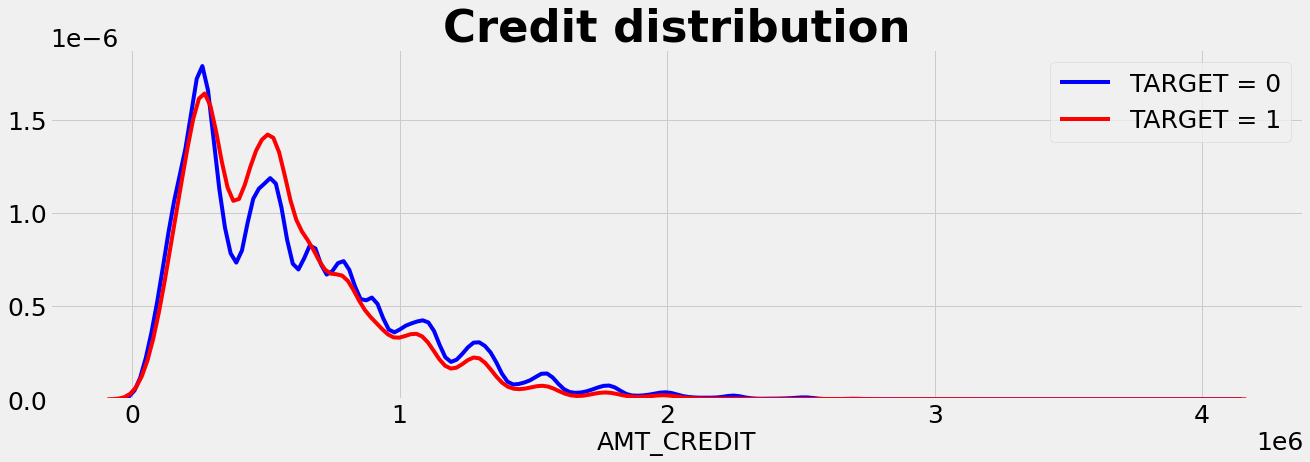

                                   -------------------------------------------------------


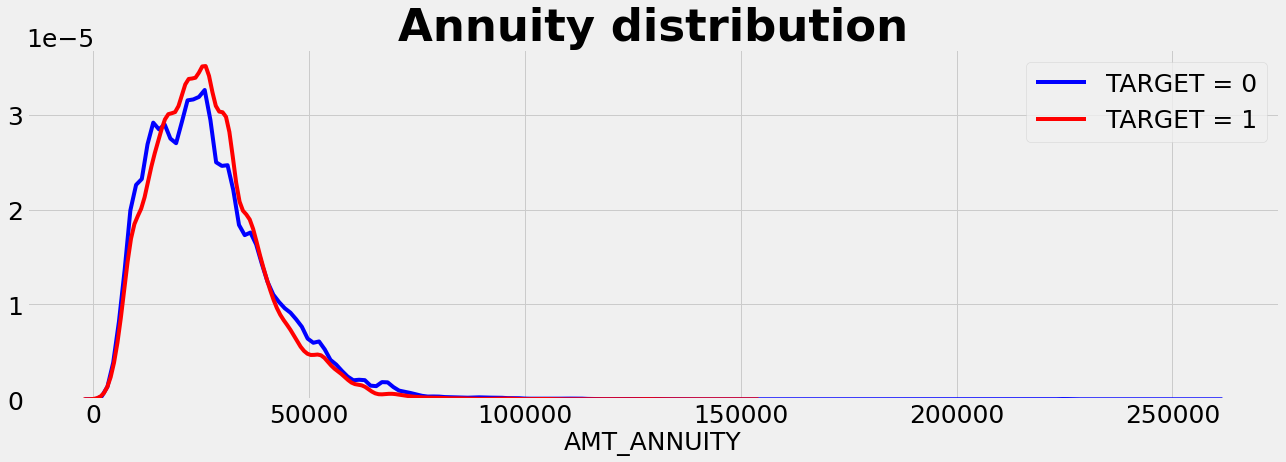

                                   -------------------------------------------------------


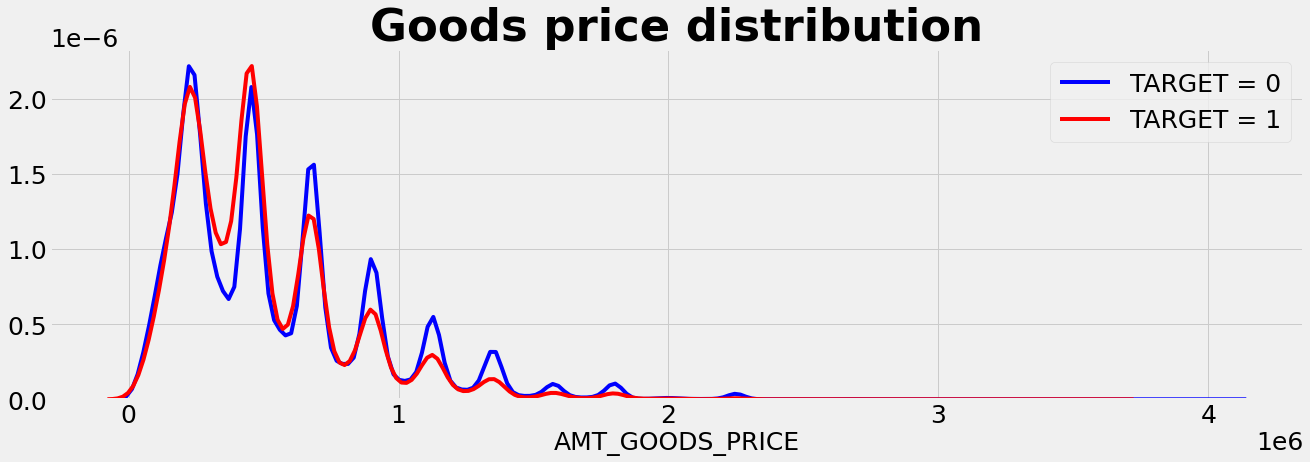

                                   -------------------------------------------------------


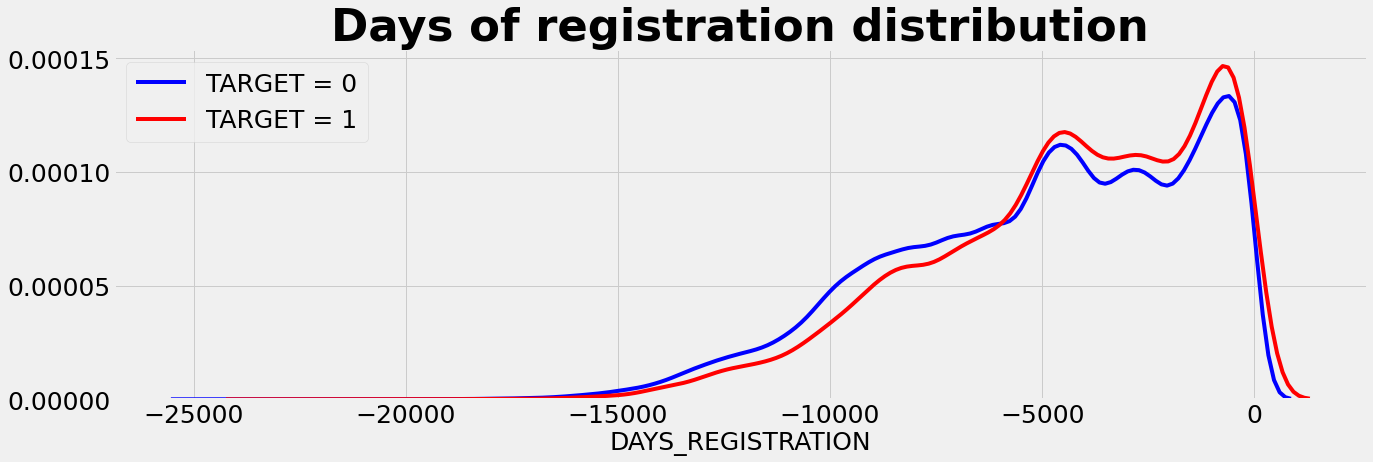

                                   -------------------------------------------------------


In [254]:
plot_distribution('AMT_CREDIT', "Credit distribution")
print("                                   -------------------------------------------------------")
plot_distribution('AMT_ANNUITY', "Annuity distribution")
print("                                   -------------------------------------------------------")
plot_distribution('AMT_GOODS_PRICE', "Goods price distribution")
print("                                   -------------------------------------------------------")
plot_distribution('DAYS_REGISTRATION', "Days of registration distribution")
print("                                   -------------------------------------------------------")

### EDA bureau.csv

``Bureau data``

Ce fichier contient tous les crédits antérieurs des clients fournis par d'autres institutions financières qui ont été déclarés au Bureau de crédit (pour les clients qui ont un prêt dans l'échantillon). Pour chaque prêt de l'échantillon, il y a autant de lignes que de nombre de crédits que le client avait au bureau de crédit avant la date de la demande. SK_ID_CURR est la clé reliant les données application_train | test aux données du bureau.

Il est nécessaire de fusionner "application_train" avec "bureau" pour pour pouvoir extraire la part de TARGET == 1.

In [255]:
application_bureau_train = application_train.merge(bureau, left_on='SK_ID_CURR', right_on='SK_ID_CURR', how='inner')

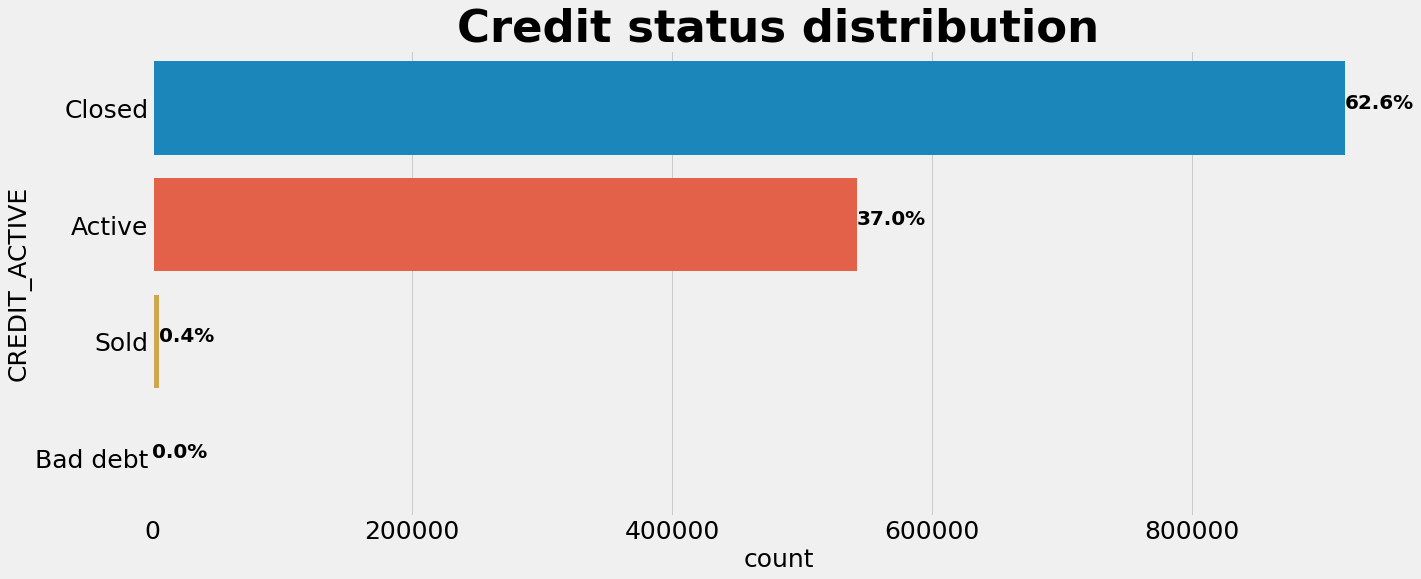

                                   -------------------------------------------------------


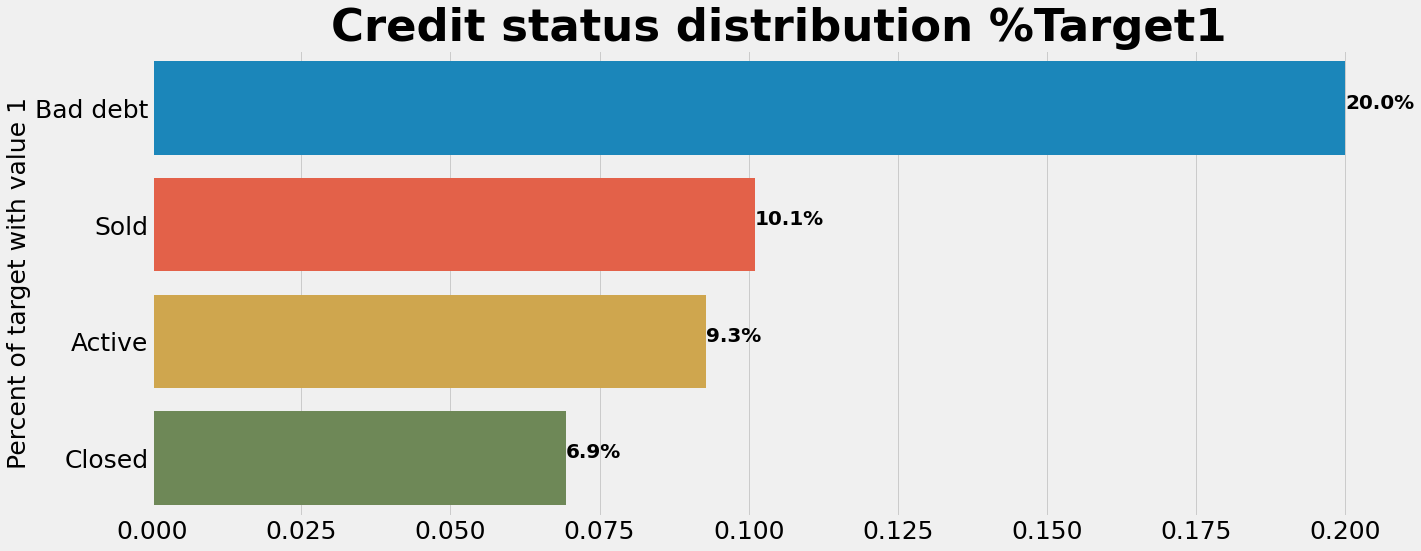

In [256]:
#CREDIT_ACTIVE
plot_stat(application_bureau_train, 'CREDIT_ACTIVE',"Credit status distribution")
print("                                   -------------------------------------------------------")
plot_percent_target1(application_bureau_train, 'CREDIT_ACTIVE',"Credit status distribution %Target1")

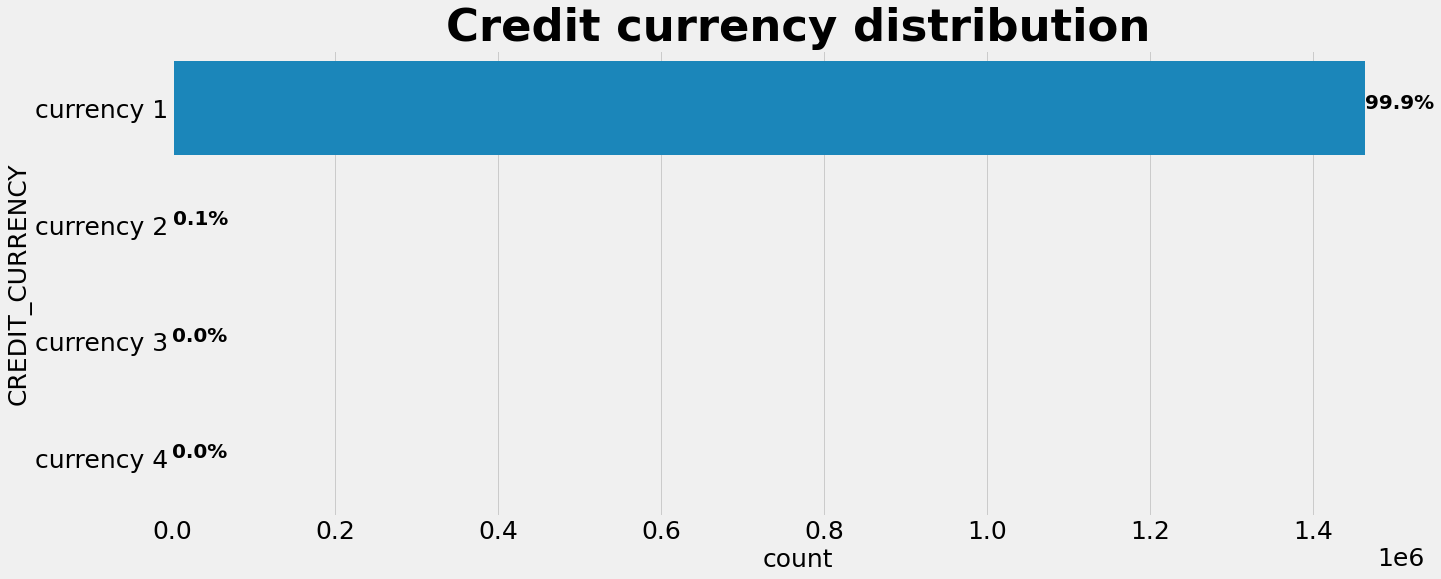

                                   -------------------------------------------------------


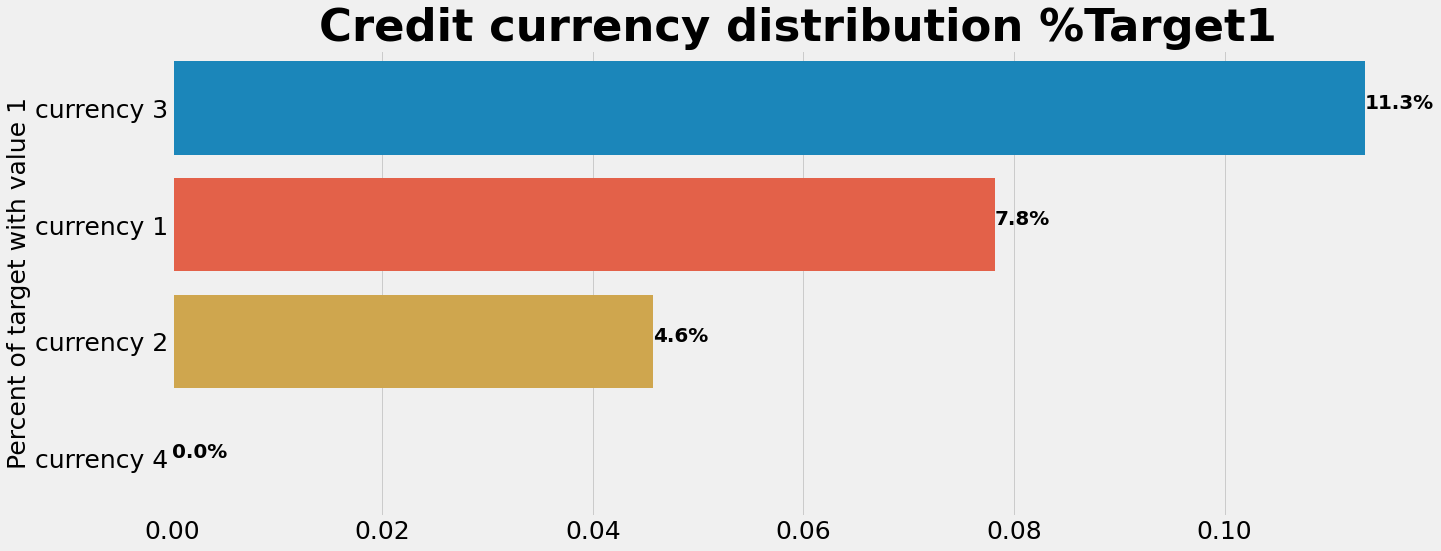

In [257]:
#CREDIT_CURRENCY
plot_stat(application_bureau_train, 'CREDIT_CURRENCY',"Credit currency distribution")
print("                                   -------------------------------------------------------")
plot_percent_target1(application_bureau_train, 'CREDIT_CURRENCY',"Credit currency distribution %Target1")

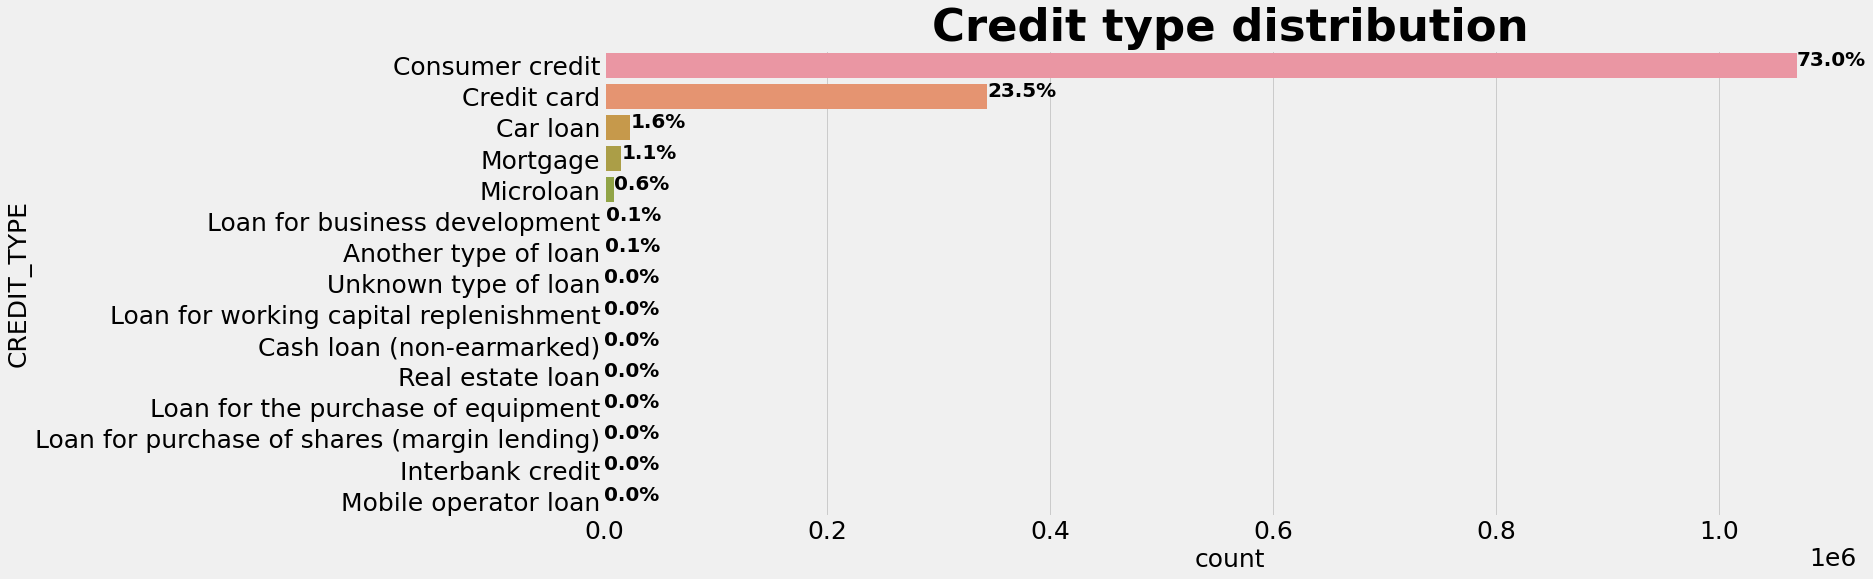

                                   -------------------------------------------------------


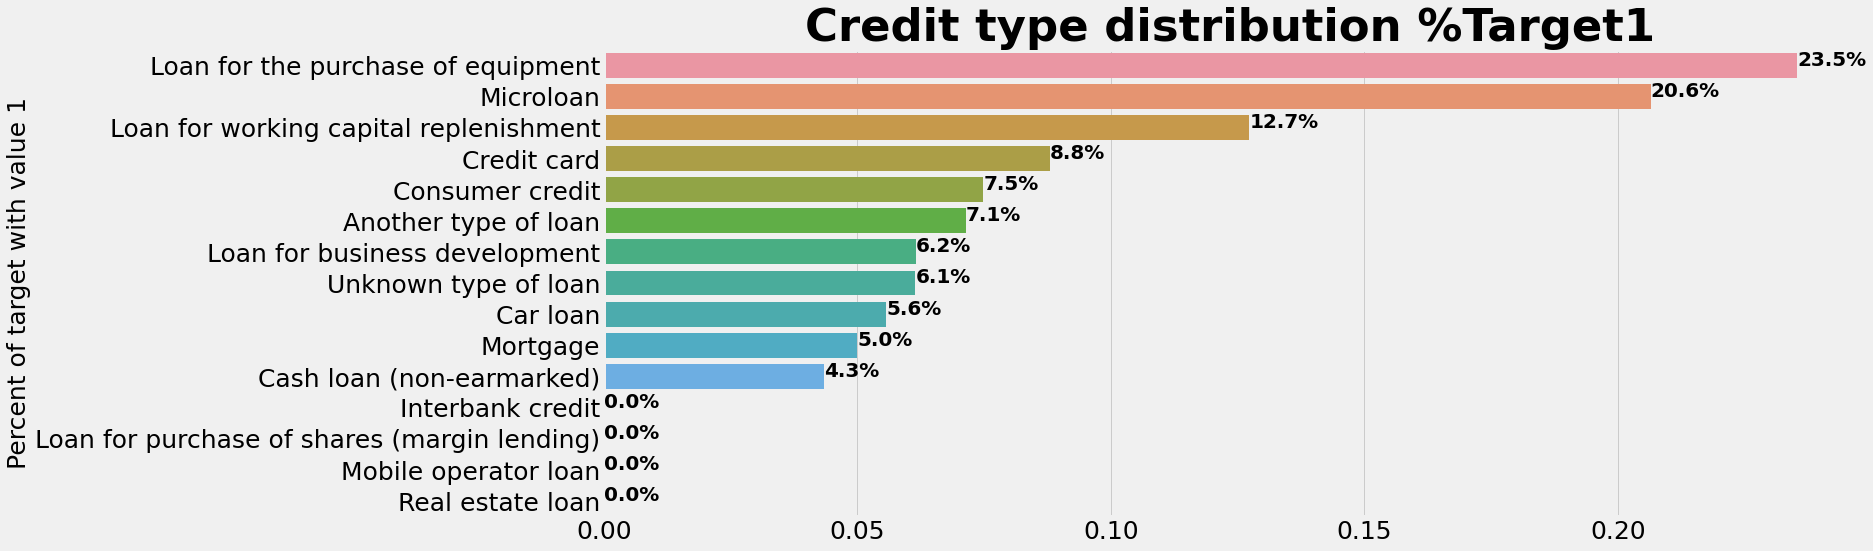

In [258]:
#CREDIT_TYPE
plot_stat(application_bureau_train, 'CREDIT_TYPE',"Credit type distribution")
print("                                   -------------------------------------------------------")
plot_percent_target1(application_bureau_train, 'CREDIT_TYPE',"Credit type distribution %Target1")

### EDA previous_application.csv

``Previous application data``

"previous_application" contient des informations sur toutes les demandes précédentes de crédit immobilier des clients qui ont des prêts dans l'échantillon. Il y a une ligne pour chaque demande précédente liée aux prêts dans notre échantillon de données. SK_ID_CURR est la clé reliant les données application_train | test aux données previous_application.


Il est nécessaire de fusionner "application_train" avec "previous_application" pour pour pouvoir extraire la part de TARGET == 1.

In [259]:
application_prev_train = application_train.merge(previous_application, 
                                                 left_on='SK_ID_CURR', right_on='SK_ID_CURR', how='inner')

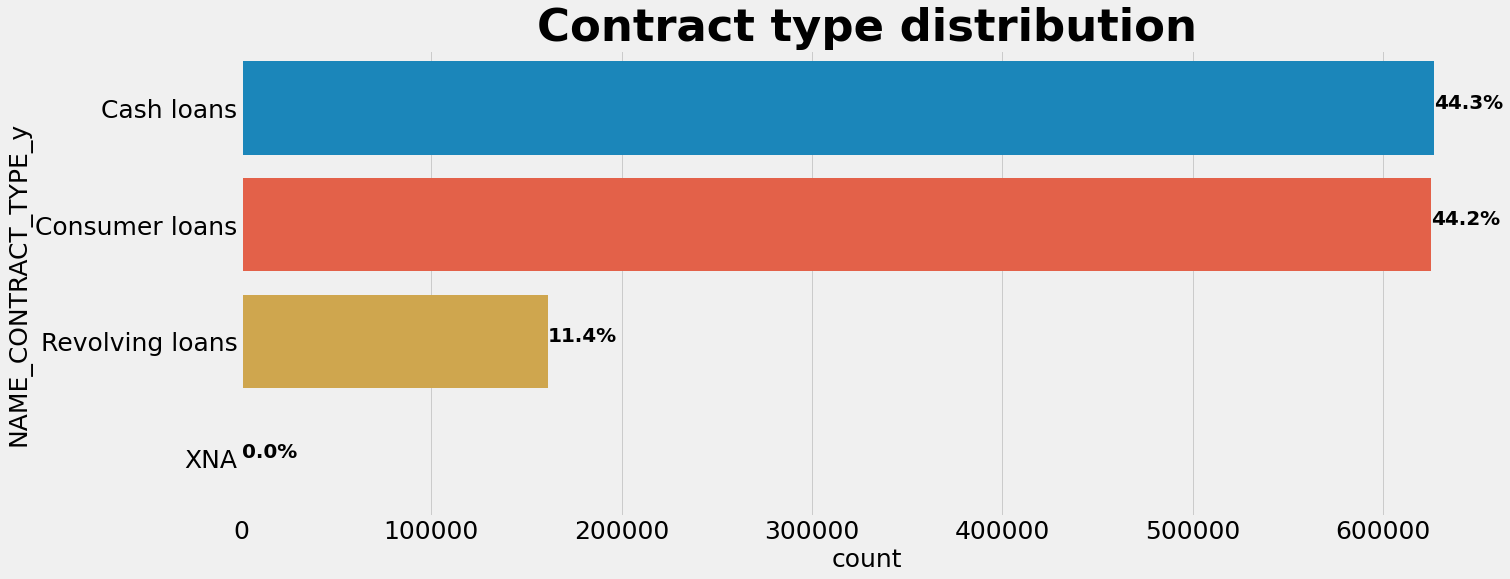

                                   -------------------------------------------------------


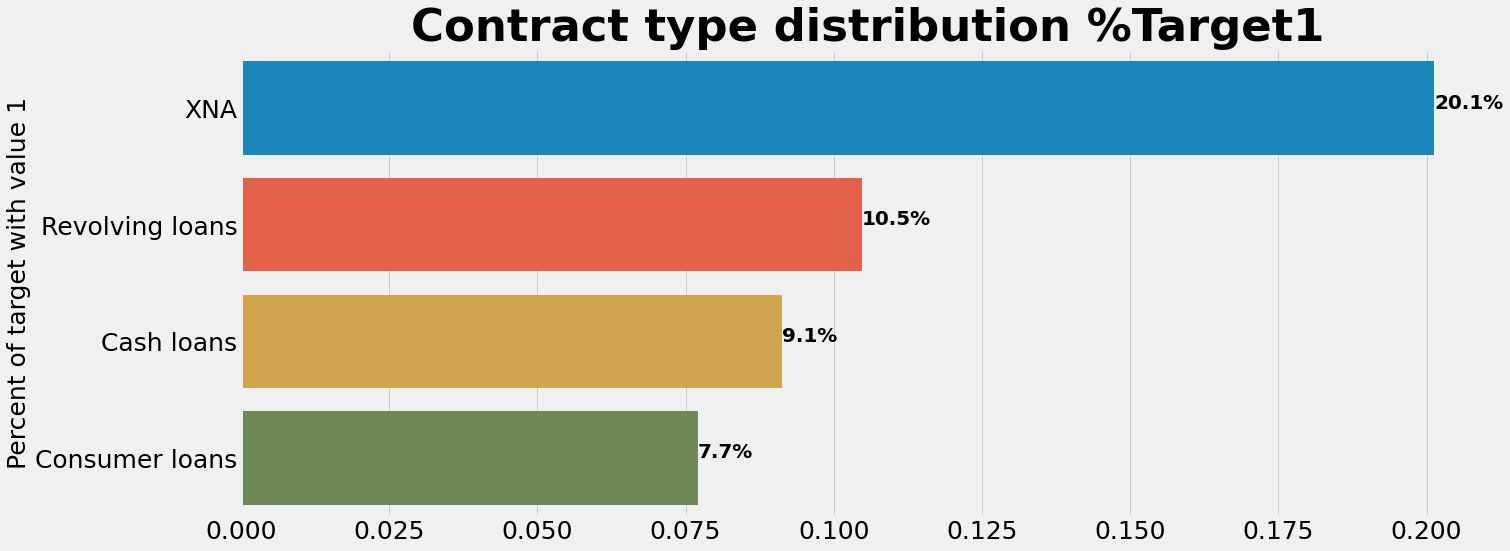

In [260]:
#NAME_CONTRACT_TYPE_y
plot_stat(application_prev_train, 'NAME_CONTRACT_TYPE_y',"Contract type distribution")
print("                                   -------------------------------------------------------")
plot_percent_target1(application_prev_train, 'NAME_CONTRACT_TYPE_y',"Contract type distribution %Target1")

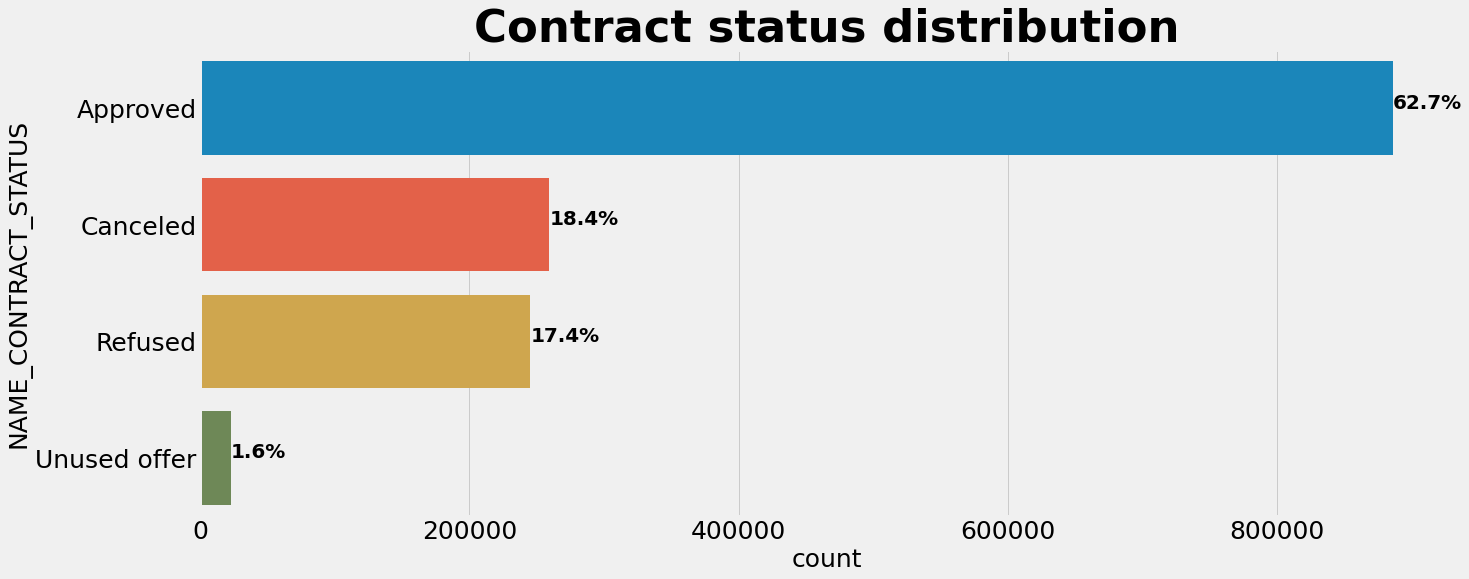

                                   -------------------------------------------------------


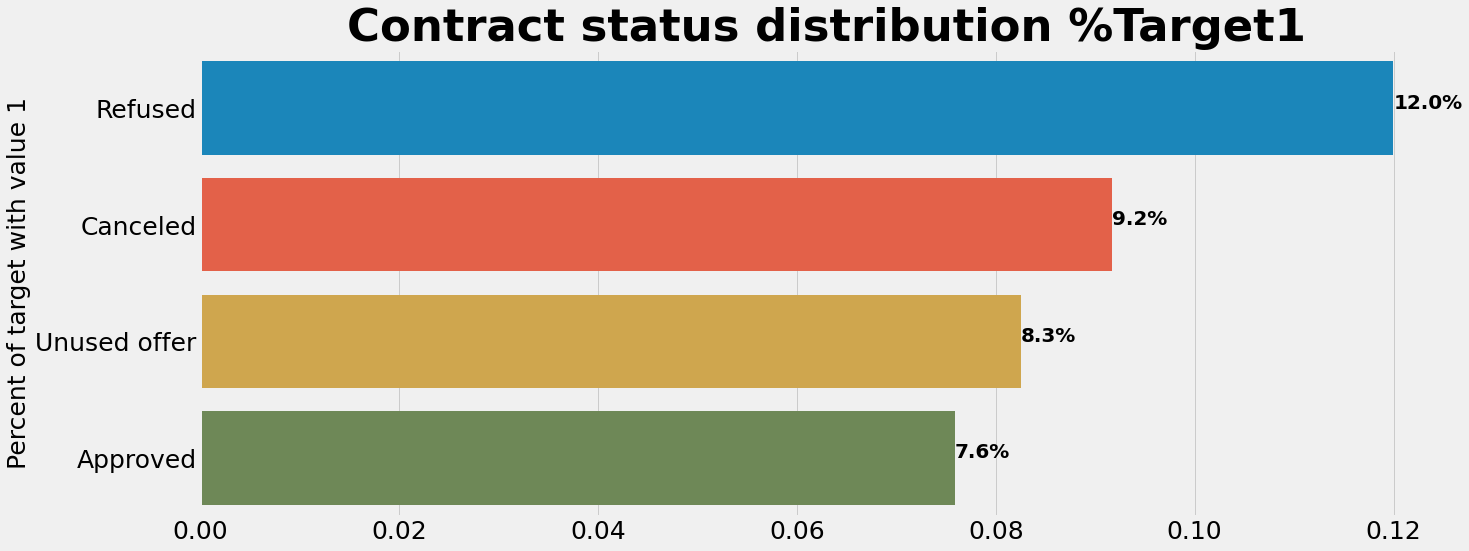

In [261]:
#NAME_CONTRACT_STATUS
plot_stat(application_prev_train, 'NAME_CONTRACT_STATUS',"Contract status distribution")
print("                                   -------------------------------------------------------")
plot_percent_target1(application_prev_train, 'NAME_CONTRACT_STATUS',"Contract status distribution %Target1")

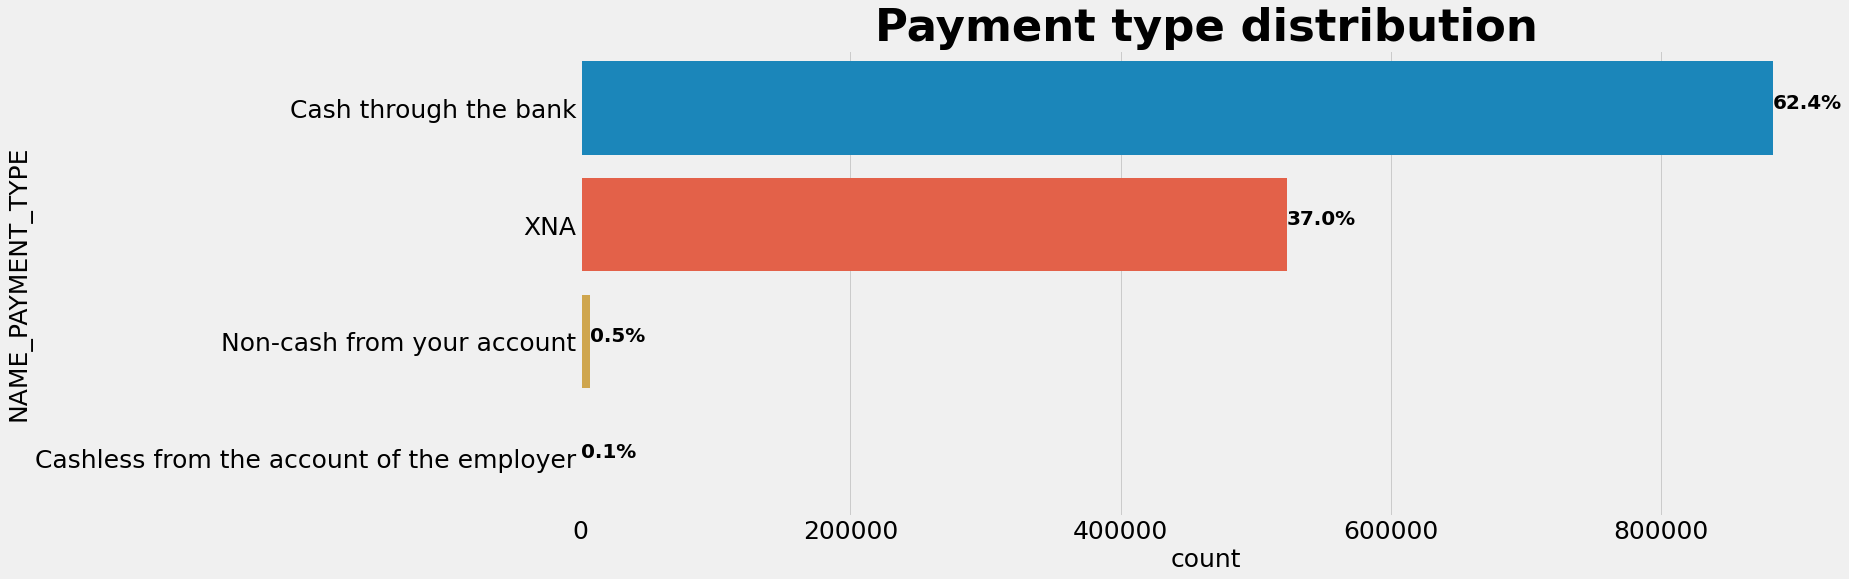

                                   -------------------------------------------------------


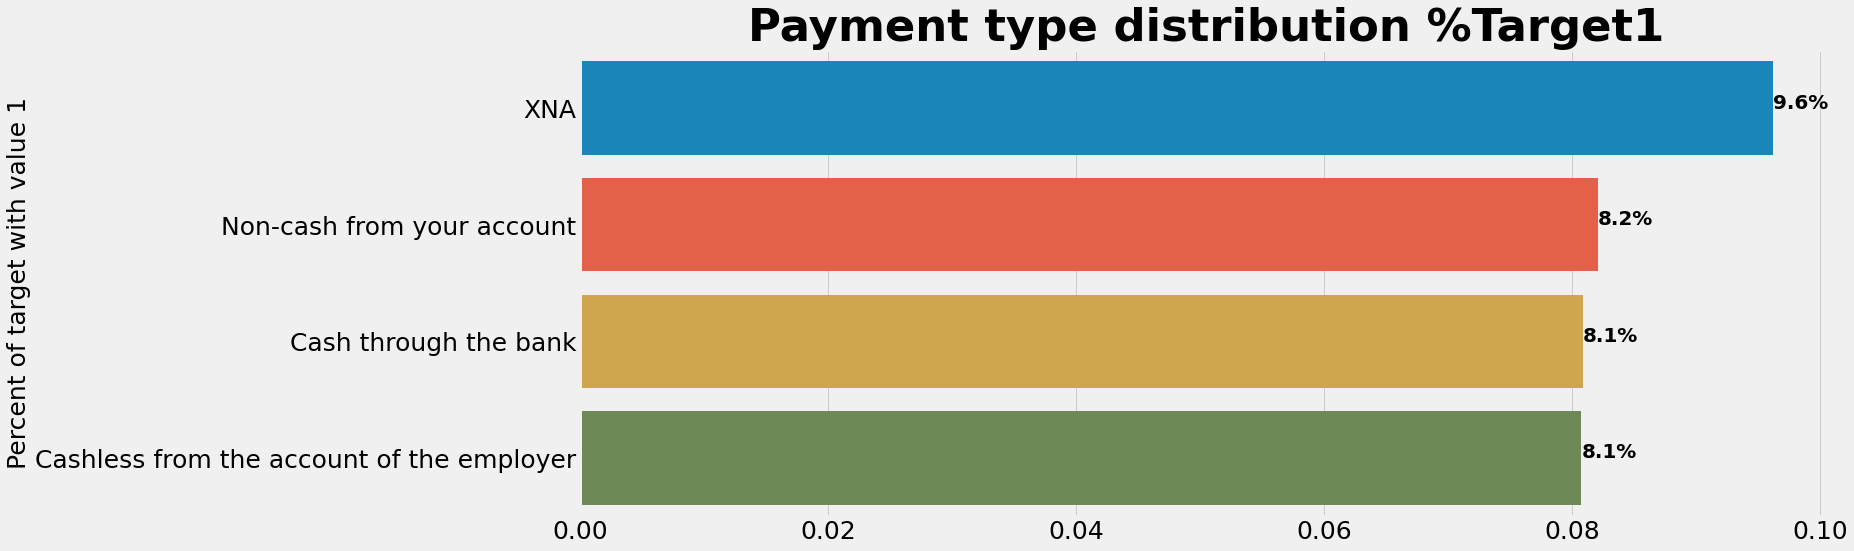

In [262]:
#NAME_PAYMENT_TYPE
plot_stat(application_prev_train, 'NAME_PAYMENT_TYPE',"Payment type distribution")
print("                                   -------------------------------------------------------")
plot_percent_target1(application_prev_train, 'NAME_PAYMENT_TYPE',"Payment type distribution %Target1")

Le mode de paiement se fait majoritairement en Cash via la banque. Le remboursement du crédit en cas de défaillance (Target 1) ne se dintingue sur aucun type de paiement, l'égalité est quasi parfaite.

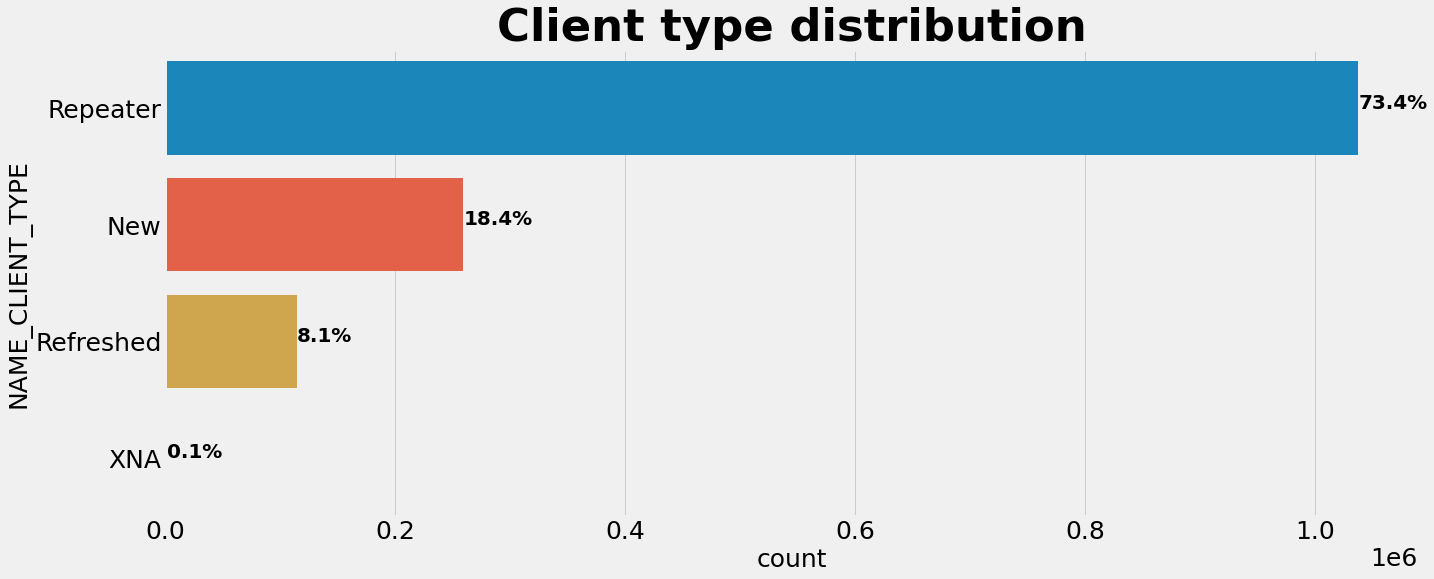

                                   -------------------------------------------------------


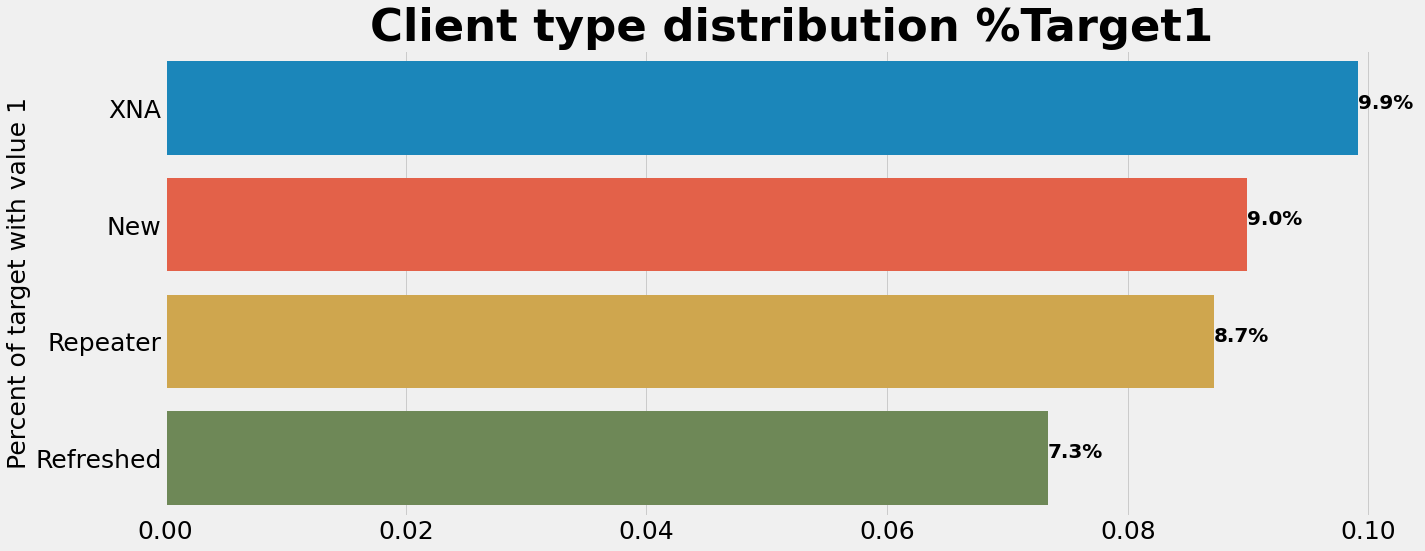

In [263]:
#NAME_CLIENT_TYPE
plot_stat(application_prev_train, 'NAME_CLIENT_TYPE',"Client type distribution")
print("                                   -------------------------------------------------------")
plot_percent_target1(application_prev_train, 'NAME_CLIENT_TYPE',"Client type distribution %Target1")

## Merging et agrégations des données
Indispensable d'avoir une réflexion et une étape d'agrégation des données. Des informations complémentaires aux principaux fichiers peuvent en effet avoir un impact dans nos modélisations. Voyons comment traiter l'ensemble des jeux de données…

In [264]:
#Create a simple dataset with the train / test merge app
data = application_train.append(application_test)

/var/folders/l6/tn22gfrx65v_ztwf3_7c6lt80000gn/T/ipykernel_86423/1925109627.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = application_train.append(application_test)


Les deux jeux de données ont exactement le même format avec une seule différence, la TARGET dispo dans le train.

In [265]:
print('Train:' + str(application_train.shape))
print('Test:' + str(application_test.shape))
print('>>> Data:' + str(data.shape))

Train:(307511, 123)
Test:(48744, 122)
>>> Data:(356255, 123)


In [266]:
#Now just in case, let's check if we've got it right
data.TARGET.isna().sum()

48744

In [267]:
sum(data.SK_ID_CURR[data.TARGET.isna()] == application_test.SK_ID_CURR) #all is good

48744

In [268]:
sum(data.SK_ID_CURR.isin(application_test.SK_ID_CURR)) == len(application_test) #nothing else to prove

True

A partir du fichier ``bureau.csv``, il est possible d'extraire un historique sur les précédents crédits enregistrés par les clients. Il peut donc être intéressant d'enrichir l'échantillon avec ce type de données.

``bureau : bureau.csv``

In [269]:
display(bureau.head())
display(bureau.shape)

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN


(1716428, 17)

Calcul du nombre total des précédents crédits pris par chaque client. Ce type d'information viendra enrichir l'échantillon de travail… 

In [270]:
#Total number of previous credits taken by each customer
previous_loan_counts = bureau.groupby('SK_ID_CURR', as_index=False)['SK_ID_BUREAU'].count().rename(
                                       columns = {'SK_ID_BUREAU': 'PREVIOUS_LOANS_COUNT'})
previous_loan_counts.head()

,SK_ID_CURR,PREVIOUS_LOANS_COUNT
0,100001,7
1,100002,8
2,100003,4
3,100004,2
4,100005,3


In [271]:
#Merge this new column in our data sample
data = data.merge(previous_loan_counts, on='SK_ID_CURR', how='left')
data.shape

(356255, 124)

``bureau_balance : bureau_balance.csv``

In [272]:
display(bureau_balance.head())
display(bureau_balance.shape)

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C
3,5715448,-3,C
4,5715448,-4,C


(27299925, 3)

In [273]:
#Monthly average balances of previous credits in Credit Bureau.
bureau_bal_mean = bureau_balance.groupby('SK_ID_BUREAU', as_index=False).mean().rename(columns = 
                                        {'MONTHS_BALANCE': 'MONTHS_BALANCE_MEAN'})
bureau_bal_mean.head()

,SK_ID_BUREAU,MONTHS_BALANCE_MEAN
0,5001709,-48.0
1,5001710,-41.0
2,5001711,-1.5
3,5001712,-9.0
4,5001713,-10.5


In [274]:
bureau_full = bureau.merge(bureau_bal_mean, on='SK_ID_BUREAU', how='left')
bureau_full.drop('SK_ID_BUREAU', axis=1, inplace=True)
display(bureau_full.head())
display(bureau_full.shape)

,SK_ID_CURR,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY,MONTHS_BALANCE_MEAN
0,215354,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN,NaN
1,215354,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN,NaN
2,215354,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN,NaN
3,215354,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN,NaN
4,215354,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN,NaN


(1716428, 17)

In [275]:
bureau_mean = bureau_full.groupby('SK_ID_CURR', as_index=False).mean().add_prefix('PREV_BUR_MEAN_')
bureau_mean = bureau_mean.rename(columns = {'PREV_BUR_MEAN_SK_ID_CURR' : 'SK_ID_CURR'})
bureau_mean.shape

(305811, 14)

In [276]:
#Merge all this features with our data sample
data = data.merge(bureau_mean, on='SK_ID_CURR', how='left')
data.shape

(356255, 137)

Notons l'enrichissement avec 13 nouvelles features, créées et ajoutées à notre ensemble de données application train/test appelé ``data``.

``previous_application``

Vérification des valeurs de 'SK_ID_CURR' entre data et previous_application…

In [277]:
display(previous_application.head())
display(previous_application.shape)

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,FLAG_LAST_APPL_PER_CONTRACT,NFLAG_LAST_APPL_IN_DAY,RATE_DOWN_PAYMENT,RATE_INTEREST_PRIMARY,RATE_INTEREST_PRIVILEGED,NAME_CASH_LOAN_PURPOSE,NAME_CONTRACT_STATUS,DAYS_DECISION,NAME_PAYMENT_TYPE,CODE_REJECT_REASON,NAME_TYPE_SUITE,NAME_CLIENT_TYPE,NAME_GOODS_CATEGORY,NAME_PORTFOLIO,NAME_PRODUCT_TYPE,CHANNEL_TYPE,SELLERPLACE_AREA,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,1730.430,17145.0,17145.0,0.0,17145.0,SATURDAY,15,Y,1,0.0,0.182832,0.867336,XAP,Approved,-73,Cash through the bank,XAP,NaN,Repeater,Mobile,POS,XNA,Country-wide,35,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0
1,2802425,108129,Cash loans,25188.615,607500.0,679671.0,NaN,607500.0,THURSDAY,11,Y,1,NaN,NaN,NaN,XNA,Approved,-164,XNA,XAP,Unaccompanied,Repeater,XNA,Cash,x-sell,Contact center,-1,XNA,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0
2,2523466,122040,Cash loans,15060.735,112500.0,136444.5,NaN,112500.0,TUESDAY,11,Y,1,NaN,NaN,NaN,XNA,Approved,-301,Cash through the bank,XAP,"Spouse, partner",Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,12.0,high,Cash X-Sell: high,365243.0,-271.0,59.0,365243.0,365243.0,1.0
3,2819243,176158,Cash loans,47041.335,450000.0,470790.0,NaN,450000.0,MONDAY,7,Y,1,NaN,NaN,NaN,XNA,Approved,-512,Cash through the bank,XAP,NaN,Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,12.0,middle,Cash X-Sell: middle,365243.0,-482.0,-152.0,-182.0,-177.0,1.0
4,1784265,202054,Cash loans,31924.395,337500.0,404055.0,NaN,337500.0,THURSDAY,9,Y,1,NaN,NaN,NaN,Repairs,Refused,-781,Cash through the bank,HC,NaN,Repeater,XNA,Cash,walk-in,Credit and cash offices,-1,XNA,24.0,high,Cash Street: high,NaN,NaN,NaN,NaN,NaN,NaN


(1670214, 37)

In [278]:
#Check 
len(previous_application.SK_ID_CURR.isin(data.SK_ID_CURR)) == len(previous_application)

True

Comme précédemment, commençons par quantifier le nombre de demandes précédentes des clients au crédit immobilier et ajoutons cette données à l'échantillon.

In [279]:
#Number of previous applications of the clients to Home Credit
previous_application_counts = previous_application.groupby('SK_ID_CURR', 
                                                           as_index=False)['SK_ID_PREV'].count().rename(
                                                           columns = {'SK_ID_PREV': 'PREVIOUS_APPLICATION_COUNT'})
previous_application_counts.head()

,SK_ID_CURR,PREVIOUS_APPLICATION_COUNT
0,100001,1
1,100002,1
2,100003,3
3,100004,1
4,100005,2


In [280]:
#Merge this new column in our data sample
data = data.merge(previous_application_counts, on='SK_ID_CURR', how='left')
data.shape

(356255, 138)

``credit_card_balance``

In [281]:
display(credit_card_balance.head())
display(credit_card_balance.shape)

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,AMT_PAYMENT_CURRENT,AMT_PAYMENT_TOTAL_CURRENT,AMT_RECEIVABLE_PRINCIPAL,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,2562384,378907,-6,56.970,135000,0.0,877.5,0.0,877.5,1700.325,1800.0,1800.0,0.000,0.000,0.000,0.0,1,0.0,1.0,35.0,Active,0,0
1,2582071,363914,-1,63975.555,45000,2250.0,2250.0,0.0,0.0,2250.000,2250.0,2250.0,60175.080,64875.555,64875.555,1.0,1,0.0,0.0,69.0,Active,0,0
2,1740877,371185,-7,31815.225,450000,0.0,0.0,0.0,0.0,2250.000,2250.0,2250.0,26926.425,31460.085,31460.085,0.0,0,0.0,0.0,30.0,Active,0,0
3,1389973,337855,-4,236572.110,225000,2250.0,2250.0,0.0,0.0,11795.760,11925.0,11925.0,224949.285,233048.970,233048.970,1.0,1,0.0,0.0,10.0,Active,0,0
4,1891521,126868,-1,453919.455,450000,0.0,11547.0,0.0,11547.0,22924.890,27000.0,27000.0,443044.395,453919.455,453919.455,0.0,1,0.0,1.0,101.0,Active,0,0


(3840312, 23)

In [282]:
credit_card_balance.drop('SK_ID_CURR', axis=1, inplace=True)

In [283]:
credit_card_balance_mean = credit_card_balance.groupby('SK_ID_PREV', as_index=False).mean().add_prefix('CARD_MEAN_')
credit_card_balance_mean.rename(columns = {'CARD_MEAN_SK_ID_PREV' : 'SK_ID_PREV'}, inplace=True)
credit_card_balance_mean.shape

(104307, 21)

In [284]:
#Merge with previous_application
previous_application = previous_application.merge(credit_card_balance_mean, on='SK_ID_PREV', how='left')
previous_application.shape

(1670214, 57)

``installments_payments``

In [285]:
display(installments_payments.head())
display(installments_payments.shape)

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,1054186,161674,1.0,6,-1180.0,-1187.0,6948.360,6948.360
1,1330831,151639,0.0,34,-2156.0,-2156.0,1716.525,1716.525
2,2085231,193053,2.0,1,-63.0,-63.0,25425.000,25425.000
3,2452527,199697,1.0,3,-2418.0,-2426.0,24350.130,24350.130
4,2714724,167756,1.0,2,-1383.0,-1366.0,2165.040,2160.585


(13605401, 8)

In [286]:
installments_payments.drop('SK_ID_CURR', axis=1, inplace=True)

In [287]:
install_pay_mean = installments_payments.groupby('SK_ID_PREV', as_index=False).mean().add_prefix('INSTALL_MEAN_')
install_pay_mean.rename(columns = {'INSTALL_MEAN_SK_ID_PREV' : 'SK_ID_PREV'}, inplace=True)
install_pay_mean.shape

(997752, 7)

In [288]:
#Merge with previous_application
previous_application = previous_application.merge(install_pay_mean, on='SK_ID_PREV', how='left')
previous_application.shape

(1670214, 63)

``POS_CASH_balance``

In [289]:
display(POS_CASH_balance.head())
display(POS_CASH_balance.shape)

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,1803195,182943,-31,48.0,45.0,Active,0,0
1,1715348,367990,-33,36.0,35.0,Active,0,0
2,1784872,397406,-32,12.0,9.0,Active,0,0
3,1903291,269225,-35,48.0,42.0,Active,0,0
4,2341044,334279,-35,36.0,35.0,Active,0,0


(10001358, 8)

In [290]:
POS_CASH_balance.drop('SK_ID_CURR', axis=1, inplace=True)

In [291]:
POS_mean = installments_payments.groupby('SK_ID_PREV', as_index=False).mean().add_prefix('POS_MEAN_')
POS_mean.rename(columns = {'POS_MEAN_SK_ID_PREV' : 'SK_ID_PREV'}, inplace=True)
POS_mean.shape

(997752, 7)

In [292]:
#Merge with previous_application
previous_application = previous_application.merge(POS_mean, on='SK_ID_PREV', how='left')
previous_application.shape

(1670214, 69)

``previous_application``

Retour sur ``previous_application`` pour assembles les lignes d'observation selon 'SK_ID_CURR'.

In [293]:
display(previous_application.head())
display(previous_application.shape)

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,FLAG_LAST_APPL_PER_CONTRACT,NFLAG_LAST_APPL_IN_DAY,RATE_DOWN_PAYMENT,RATE_INTEREST_PRIMARY,RATE_INTEREST_PRIVILEGED,NAME_CASH_LOAN_PURPOSE,NAME_CONTRACT_STATUS,DAYS_DECISION,NAME_PAYMENT_TYPE,CODE_REJECT_REASON,NAME_TYPE_SUITE,NAME_CLIENT_TYPE,NAME_GOODS_CATEGORY,NAME_PORTFOLIO,NAME_PRODUCT_TYPE,CHANNEL_TYPE,SELLERPLACE_AREA,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL,CARD_MEAN_MONTHS_BALANCE,CARD_MEAN_AMT_BALANCE,CARD_MEAN_AMT_CREDIT_LIMIT_ACTUAL,CARD_MEAN_AMT_DRAWINGS_ATM_CURRENT,CARD_MEAN_AMT_DRAWINGS_CURRENT,CARD_MEAN_AMT_DRAWINGS_OTHER_CURRENT,CARD_MEAN_AMT_DRAWINGS_POS_CURRENT,CARD_MEAN_AMT_INST_MIN_REGULARITY,CARD_MEAN_AMT_PAYMENT_CURRENT,CARD_MEAN_AMT_PAYMENT_TOTAL_CURRENT,CARD_MEAN_AMT_RECEIVABLE_PRINCIPAL,CARD_MEAN_AMT_RECIVABLE,CARD_MEAN_AMT_TOTAL_RECEIVABLE,CARD_MEAN_CNT_DRAWINGS_ATM_CURRENT,CARD_MEAN_CNT_DRAWINGS_CURRENT,CARD_MEAN_CNT_DRAWINGS_OTHER_CURRENT,CARD_MEAN_CNT_DRAWINGS_POS_CURRENT,CARD_MEAN_CNT_INSTALMENT_MATURE_CUM,CARD_MEAN_SK_DPD,CARD_MEAN_SK_DPD_DEF,INSTALL_MEAN_NUM_INSTALMENT_VERSION,INSTALL_MEAN_NUM_INSTALMENT_NUMBER,INSTALL_MEAN_DAYS_INSTALMENT,INSTALL_MEAN_DAYS_ENTRY_PAYMENT,INSTALL_MEAN_AMT_INSTALMENT,INSTALL_MEAN_AMT_PAYMENT,POS_MEAN_NUM_INSTALMENT_VERSION,POS_MEAN_NUM_INSTALMENT_NUMBER,POS_MEAN_DAYS_INSTALMENT,POS_MEAN_DAYS_ENTRY_PAYMENT,POS_MEAN_AMT_INSTALMENT,POS_MEAN_AMT_PAYMENT
0,2030495,271877,Consumer loans,1730.430,17145.0,17145.0,0.0,17145.0,SATURDAY,15,Y,1,0.0,0.182832,0.867336,XAP,Approved,-73,Cash through the bank,XAP,NaN,Repeater,Mobile,POS,XNA,Country-wide,35,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.000000,1.0,-42.0,-42.000000,17284.275000,17284.275000,2.000000,1.0,-42.0,-42.000000,17284.275000,17284.275000
1,2802425,108129,Cash loans,25188.615,607500.0,679671.0,NaN,607500.0,THURSDAY,11,Y,1,NaN,NaN,NaN,XNA,Approved,-164,XNA,XAP,Unaccompanied,Repeater,XNA,Cash,x-sell,Contact center,-1,XNA,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,3.0,-74.0,-83.200000,25188.615000,25188.615000,1.000000,3.0,-74.0,-83.200000,25188.615000,25188.615000
2,2523466,122040,Cash loans,15060.735,112500.0,136444.5,NaN,112500.0,TUESDAY,11,Y,1,NaN,NaN,NaN,XNA,Approved,-301,Cash through the bank,XAP,"Spouse, partner",Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,12.0,high,Cash X-Sell: high,365243.0,-271.0,59.0,365243.0,365243.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,5.0,-151.0,-159.222222,15060.735000,15060.735000,1.000000,5.0,-151.0,-159.222222,15060.735000,15060.735000
3,2819243,176158,Cash loans,47041.335,450000.0,470790.0,NaN,450000.0,MONDAY,7,Y,1,NaN,NaN,NaN,XNA,Approved,-512,Cash through the bank,XAP,NaN,Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,12.0,middle,Cash X-Sell: middle,365243.0,-482.0,-152.0,-182.0,-177.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.090909,6.0,-332.0,-339.090909,51193.943182,51193.943182,1.090909,6.0,-332.0,-339.090909,51193.943182,51193.943182
4,1784265,202054,Cash loans,31924.395,337500.0,404055.0,NaN,337500.0,THURSDAY,9,Y,1,NaN,NaN,NaN,Repairs,Refused,-781,Cash through the bank,HC,NaN,Repeater,XNA,Cash,walk-in,Credit and cash offices,-1,XNA,24.0,high,Cash Street: high,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


(1670214, 69)

In [294]:
prev_appl_mean = previous_application.groupby('SK_ID_CURR', as_index=False).mean().add_prefix('PREV_APPL_MEAN_')
prev_appl_mean.rename(columns = {'PREV_APPL_MEAN_SK_ID_CURR' : 'SK_ID_CURR'}, inplace=True)
prev_appl_mean = prev_appl_mean.drop('PREV_APPL_MEAN_SK_ID_PREV', axis=1)

In [295]:
display(prev_appl_mean.head())
display(prev_appl_mean.shape)

,SK_ID_CURR,PREV_APPL_MEAN_AMT_ANNUITY,PREV_APPL_MEAN_AMT_APPLICATION,PREV_APPL_MEAN_AMT_CREDIT,PREV_APPL_MEAN_AMT_DOWN_PAYMENT,PREV_APPL_MEAN_AMT_GOODS_PRICE,PREV_APPL_MEAN_HOUR_APPR_PROCESS_START,PREV_APPL_MEAN_NFLAG_LAST_APPL_IN_DAY,PREV_APPL_MEAN_RATE_DOWN_PAYMENT,PREV_APPL_MEAN_RATE_INTEREST_PRIMARY,PREV_APPL_MEAN_RATE_INTEREST_PRIVILEGED,PREV_APPL_MEAN_DAYS_DECISION,PREV_APPL_MEAN_SELLERPLACE_AREA,PREV_APPL_MEAN_CNT_PAYMENT,PREV_APPL_MEAN_DAYS_FIRST_DRAWING,PREV_APPL_MEAN_DAYS_FIRST_DUE,PREV_APPL_MEAN_DAYS_LAST_DUE_1ST_VERSION,PREV_APPL_MEAN_DAYS_LAST_DUE,PREV_APPL_MEAN_DAYS_TERMINATION,PREV_APPL_MEAN_NFLAG_INSURED_ON_APPROVAL,PREV_APPL_MEAN_CARD_MEAN_MONTHS_BALANCE,PREV_APPL_MEAN_CARD_MEAN_AMT_BALANCE,PREV_APPL_MEAN_CARD_MEAN_AMT_CREDIT_LIMIT_ACTUAL,PREV_APPL_MEAN_CARD_MEAN_AMT_DRAWINGS_ATM_CURRENT,PREV_APPL_MEAN_CARD_MEAN_AMT_DRAWINGS_CURRENT,PREV_APPL_MEAN_CARD_MEAN_AMT_DRAWINGS_OTHER_CURRENT,PREV_APPL_MEAN_CARD_MEAN_AMT_DRAWINGS_POS_CURRENT,PREV_APPL_MEAN_CARD_MEAN_AMT_INST_MIN_REGULARITY,PREV_APPL_MEAN_CARD_MEAN_AMT_PAYMENT_CURRENT,PREV_APPL_MEAN_CARD_MEAN_AMT_PAYMENT_TOTAL_CURRENT,PREV_APPL_MEAN_CARD_MEAN_AMT_RECEIVABLE_PRINCIPAL,PREV_APPL_MEAN_CARD_MEAN_AMT_RECIVABLE,PREV_APPL_MEAN_CARD_MEAN_AMT_TOTAL_RECEIVABLE,PREV_APPL_MEAN_CARD_MEAN_CNT_DRAWINGS_ATM_CURRENT,PREV_APPL_MEAN_CARD_MEAN_CNT_DRAWINGS_CURRENT,PREV_APPL_MEAN_CARD_MEAN_CNT_DRAWINGS_OTHER_CURRENT,PREV_APPL_MEAN_CARD_MEAN_CNT_DRAWINGS_POS_CURRENT,PREV_APPL_MEAN_CARD_MEAN_CNT_INSTALMENT_MATURE_CUM,PREV_APPL_MEAN_CARD_MEAN_SK_DPD,PREV_APPL_MEAN_CARD_MEAN_SK_DPD_DEF,PREV_APPL_MEAN_INSTALL_MEAN_NUM_INSTALMENT_VERSION,PREV_APPL_MEAN_INSTALL_MEAN_NUM_INSTALMENT_NUMBER,PREV_APPL_MEAN_INSTALL_MEAN_DAYS_INSTALMENT,PREV_APPL_MEAN_INSTALL_MEAN_DAYS_ENTRY_PAYMENT,PREV_APPL_MEAN_INSTALL_MEAN_AMT_INSTALMENT,PREV_APPL_MEAN_INSTALL_MEAN_AMT_PAYMENT,PREV_APPL_MEAN_POS_MEAN_NUM_INSTALMENT_VERSION,PREV_APPL_MEAN_POS_MEAN_NUM_INSTALMENT_NUMBER,PREV_APPL_MEAN_POS_MEAN_DAYS_INSTALMENT,PREV_APPL_MEAN_POS_MEAN_DAYS_ENTRY_PAYMENT,PREV_APPL_MEAN_POS_MEAN_AMT_INSTALMENT,PREV_APPL_MEAN_POS_MEAN_AMT_PAYMENT
0,100001,3951.000,24835.50,23787.00,2520.0,24835.5,13.000000,1.0,0.104326,NaN,NaN,-1740.0,23.0,8.0,365243.0,-1709.000000,-1499.000000,-1619.000000,-1612.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.250000,2.500000,-1664.000000,-1679.500000,7312.725000,7312.725000,1.250000,2.500000,-1664.000000,-1679.500000,7312.725000,7312.725000
1,100002,9251.775,179055.00,179055.00,0.0,179055.0,9.000000,1.0,0.000000,NaN,NaN,-606.0,500.0,24.0,365243.0,-565.000000,125.000000,-25.000000,-17.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.052632,10.000000,-295.000000,-315.421053,11559.247105,11559.247105,1.052632,10.000000,-295.000000,-315.421053,11559.247105,11559.247105
2,100003,56553.990,435436.50,484191.00,3442.5,435436.5,14.666667,1.0,0.050030,NaN,NaN,-1305.0,533.0,10.0,365243.0,-1274.333333,-1004.333333,-1054.333333,-1047.333333,0.666667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.047619,4.666667,-1164.333333,-1171.781746,78558.479286,78558.479286,1.047619,4.666667,-1164.333333,-1171.781746,78558.479286,78558.479286
3,100004,5357.250,24282.00,20106.00,4860.0,24282.0,5.000000,1.0,0.212008,NaN,NaN,-815.0,30.0,4.0,365243.0,-784.000000,-694.000000,-724.000000,-714.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.333333,2.000000,-754.000000,-761.666667,7096.155000,7096.155000,1.333333,2.000000,-754.000000,-761.666667,7096.155000,7096.155000
4,100005,4813.200,22308.75,20076.75,4464.0,44617.5,10.500000,1.0,0.108964,NaN,NaN,-536.0,18.0,12.0,365243.0,-706.000000,-376.000000,-466.000000,-460.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.111111,5.000000,-586.000000,-609.555556,6240.205000,6240.205000,1.111111,5.000000,-586.000000,-609.555556,6240.205000,6240.205000


(338857, 52)

In [296]:
#Reminder…
print('data shape', data.shape)

data shape (356255, 138)


In [297]:
#Last merge with our data sample
data = data.merge(prev_appl_mean, on='SK_ID_CURR', how='left')
#data.set_index('SK_ID_CURR', inplace=True)
display(data.head())
display(data.shape)

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,DAYS_EMPLOYED_OUTLIERS,PREVIOUS_LOANS_COUNT,PREV_BUR_MEAN_DAYS_CREDIT,PREV_BUR_MEAN_CREDIT_DAY_OVERDUE,PREV_BUR_MEAN_DAYS_CREDIT_ENDDATE,PREV_BUR_MEAN_DAYS_ENDDATE_FACT,PREV_BUR_MEAN_AMT_CREDIT_MAX_OVERDUE,PREV_BUR_MEAN_CNT_CREDIT_PROLONG,PREV_BUR_MEAN_AMT_CREDIT_SUM,PREV_BUR_MEAN_AMT_CREDIT_SUM_DEBT,PREV_BUR_MEAN_AMT_CREDIT_SUM_LIMIT,PREV_BUR_MEAN_AMT_CREDIT_SUM_OVERDUE,PREV_BUR_MEAN_DAYS_CREDIT_UPDATE,PREV_BUR_MEAN_AMT_ANNUITY,PREV_BUR_MEAN_MONTHS_BALANCE_MEAN,PREVIOUS_APPLICATION_COUNT,PREV_APPL_MEAN_AMT_ANNUITY,PREV_APPL_MEAN_AMT_APPLICATION,PREV_APPL_MEAN_AMT_CREDIT,PREV_APPL_MEAN_AMT_DOWN_PAYMENT,PREV_APPL_MEAN_AMT_GOODS_PRICE,PREV_APPL_MEAN_HOUR_APPR_PROCESS_START,PREV_APPL_MEAN_NFLAG_LAST_APPL_IN_DAY,PREV_APPL_MEAN_RATE_DOWN_PAYMENT,PREV_APPL_MEAN_RATE_INTEREST_PRIMARY,PREV_APPL_MEAN_RATE_INTEREST_PRIVILEGED,PREV_APPL_MEAN_DAYS_DECISION,PREV_APPL_MEAN_SELLERPLACE_AREA,PREV_APPL_MEAN_CNT_PAYMENT,PREV_APPL_MEAN_DAYS_FIRST_DRAWING,PREV_APPL_MEAN_DAYS_FIRST_DUE,PREV_APPL_MEAN_DAYS_LAST_DUE_1ST_VERSION,PREV_APPL_MEAN_DAYS_LAST_DUE,PREV_APPL_MEAN_DAYS_TERMINATION,PREV_APPL_MEAN_NFLAG_INSURED_ON_APPROVAL,PREV_APPL_MEAN_CARD_MEAN_MONTHS_BALANCE,PREV_APPL_MEAN_CARD_MEAN_AMT_BALANCE,PREV_APPL_MEAN_CARD_MEAN_AMT_CREDIT_LIMIT_ACTUAL,PREV_APPL_MEAN_CARD_MEAN_AMT_DRAWINGS_ATM_CURRENT,PREV_APPL_MEAN_CARD_MEAN_AMT_DRAWINGS_CURRENT,PREV_APPL_MEAN_CARD_MEAN_AMT_DRAWINGS_OTHER_CURRENT,PREV_APPL_MEAN_CARD_MEAN_AMT_DRAWINGS_POS_CURRENT,PREV_APPL_MEAN_CARD_MEAN_AMT_INST_MIN_REGULARITY,PREV_APPL_MEAN_CARD_MEAN_AMT_PAYMENT_CURRENT,PREV_APPL_MEAN_CARD_MEAN_AMT_PAYMENT_TOTAL_CURRENT,PREV_APPL_MEAN_CARD_MEAN_AMT_RECEIVABLE_PRINCIPAL,PREV_APPL_MEAN_CARD_MEAN_AMT_RECIVABLE,PREV_APPL_MEAN_CARD_MEAN_AMT_TOTAL_RECEIVABLE,PREV_APPL_MEAN_CARD_MEAN_CNT_DRAWINGS_ATM_CURRENT,PREV_APPL_MEAN_CARD_M

(356255, 189)

***50 nouvelles features ont été ajoutées à l'échantillon suite aux opérations de merging.***

## Features engineering
Il peut être pertinent d'enrichir l'échantillon par un ajout de variables spécifiques à la problématique métier. N'étant pas spécialisé dans l'expertise des crédits, on pourra mener les modélisations avec une étape de features selection qui déterminera la pertinence de ces variables, ainsi que toutes les autres variables de l'échantillon.

### 3 features extraites des précédentes étapes
Pour rappel, les étapes précédentes consistaient uniquement à établir des liens entre nos fichiers, des fusions de table dans le but d'enrichir l'échantillon de travail. Ceci étant, avant de procéder au merging des éléments, on a pu facilement extraire __3 variables de moyenne et de comptage__.

``PREVIOUS_LOANS_COUNT`` from bureau.csv: Nombre total des précédents crédits pris par chaque client\
``MONTHS_BALANCE_MEAN`` from bureau_balance.csv: Solde moyen mensuel des précédents crédits\
``PREVIOUS_APPLICATION_COUNT`` from previous_application.csv: Nombre de demandes antérieures des clients au crédit immobilier



### Création de 4 nouvelles variables métiers
Sans être expert en crédit bancaire, on peut assez facilement apporter quelques ratios explicatifs. D'autant plus qu'une veille parallèle permet de mieux comprendre les enjeux attendus. Voyons ci-dessous quelles features est-il pertinent d'intégrer.

``CREDIT_INCOME_PERCENT``: Pourcentage du montant du crédit par rapport au revenu d'un client\
``ANNUITY_INCOME_PERCENT``: Pourcentage de la rente de prêt par rapport au revenu d'un client\
``CREDIT_TERM``: Durée du paiement en mois\
``DAYS_EMPLOYED_PERCENT``: Pourcentage des jours employés par rapport à l'âge du client

In [298]:
#Before…
data.shape

(356255, 189)

In [299]:
data['CREDIT_INCOME_PERCENT'] = data['AMT_CREDIT'] / data['AMT_INCOME_TOTAL']
data['ANNUITY_INCOME_PERCENT'] = data['AMT_ANNUITY'] / data['AMT_INCOME_TOTAL']
data['CREDIT_TERM'] = data['AMT_ANNUITY'] / data['AMT_CREDIT']
data['DAYS_EMPLOYED_PERCENT'] = data['DAYS_EMPLOYED'] / data['DAYS_BIRTH']

In [300]:
#After…
data.shape

(356255, 193)

In [301]:
#New Variables from features engineering
features_engin = ['PREVIOUS_LOANS_COUNT', 'MONTHS_BALANCE_MEAN', 'PREVIOUS_APPLICATION_COUNT',
                   'CREDIT_INCOME_PERCENT', 'ANNUITY_INCOME_PERCENT', 'CREDIT_TERM', 'DAYS_EMPLOYED_PERCENT']

In [302]:
#Display correlations with features engineering
print('Most Positive Correlations:\n', data.corr()['TARGET'].sort_values().tail(15))
print("--------------------------")
print('Most Negative Correlations:\n', data.corr()['TARGET'].sort_values().head(15))

Most Positive Correlations:
 REGION_RATING_CLIENT                                 0.058899
REGION_RATING_CLIENT_W_CITY                          0.060893
DAYS_EMPLOYED_PERCENT                                0.067955
PREV_BUR_MEAN_DAYS_CREDIT_UPDATE                     0.068927
PREV_APPL_MEAN_CARD_MEAN_AMT_INST_MIN_REGULARITY     0.074204
DAYS_EMPLOYED                                        0.074958
PREV_BUR_MEAN_MONTHS_BALANCE_MEAN                    0.076424
PREV_APPL_MEAN_CARD_MEAN_CNT_DRAWINGS_CURRENT        0.080885
PREV_APPL_MEAN_CARD_MEAN_AMT_RECEIVABLE_PRINCIPAL    0.085491
PREV_APPL_MEAN_CARD_MEAN_AMT_RECIVABLE               0.085963
PREV_APPL_MEAN_CARD_MEAN_AMT_TOTAL_RECEIVABLE        0.085967
PREV_APPL_MEAN_CARD_MEAN_AMT_BALANCE                 0.086693
PREV_BUR_MEAN_DAYS_CREDIT                            0.089729
PREV_APPL_MEAN_CARD_MEAN_CNT_DRAWINGS_ATM_CURRENT    0.102917
TARGET                                               1.000000
Name: TARGET, dtype: float64
------------

Les corrélations explicitées précédemment n'ont pas évoluées suite à l'extraction des 7 features.

In [303]:
data.to_csv('merged_data.csv')

## Preprocessing des données

### Split train / test data
Il est nécessaire de commencer par la mise en place des données d'entrainement / test. On peut procéder en rappel avec les jeux de données application_train/test.

In [304]:
data_train = data[data['SK_ID_CURR'].isin(application_train.SK_ID_CURR)]
data_test = data[data['SK_ID_CURR'].isin(application_test.SK_ID_CURR)]

data_test = data_test.drop('TARGET', axis=1)

In [305]:
data_train.set_index('SK_ID_CURR', inplace=True)
data_test.set_index('SK_ID_CURR', inplace=True)

In [306]:
print('Training Features shape with categorical columns: ', data_train.shape)
print('Testing Features shape with categorical columns: ', data_test.shape)

Training Features shape with categorical columns:  (307511, 192)
Testing Features shape with categorical columns:  (48744, 191)


### Encoding categorical features 


In [307]:
from sklearn.preprocessing import LabelEncoder

In [308]:
# Create a label encoder object
le = LabelEncoder()
count = 0

# Iterate through the columns
for col in data_train:
    # If 2 or fewer unique categories
    if data_train.loc[:,col].dtype == 'object' and len(list(data_train.loc[:,col].unique())) <= 2:
        # Train on the training data
        le.fit(data_train.loc[:,col])
        # Transform both training and testing data
        data_train.loc[:,col] = le.transform(data_train.loc[:,col])
        data_test.loc[:,col] = le.transform(data_test.loc[:,col])

        count += 1
            
print('%d columns were label encoded.' % count)

/var/folders/l6/tn22gfrx65v_ztwf3_7c6lt80000gn/T/ipykernel_86423/11043732.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_train.loc[:,col] = le.transform(data_train.loc[:,col])


3 columns were label encoded.


In [309]:
print('Training Features shape with categorical columns: ', data_train.shape)
print('Testing Features shape with categorical columns: ', data_test.shape)

Training Features shape with categorical columns:  (307511, 192)
Testing Features shape with categorical columns:  (48744, 191)


In [310]:
data_train = pd.get_dummies(data_train)
data_test = pd.get_dummies(data_test)

In [311]:
print('Training Features shape with categorical columns: ', data_train.shape)
print('Testing Features shape with categorical columns: ', data_test.shape)

Training Features shape with categorical columns:  (307511, 313)
Testing Features shape with categorical columns:  (48744, 309)


In [312]:
TARGET = data_train.TARGET #save our TARGET variable
data_train.drop('TARGET', axis=1, inplace=True) #remove TARGET from train

#Align the datasets
data_train, data_test = data_train.align(data_test, join='inner', axis=1)

In [313]:
print(data_train.shape)
print(data_test.shape)

(307511, 309)
(48744, 309)


In [314]:
#Copy before imputation of missing values
train = data_train.copy()
test = data_test.copy()
train.shape, test.shape

((307511, 309), (48744, 309))

### Imputation des valeurs manquantes 
L'une des approches les plus simples consiste à remplacer les NaN par la Médiane (ou Moyenne) pour les variables  correspondantes.

In [315]:
from sklearn.impute import SimpleImputer

In [316]:
print('Missing values in train data: ', sum(data_train.isnull().sum()))
print('Missing values in test data: ', sum(data_test.isnull().sum()))

Missing values in train data:  15543705
Missing values in test data:  2277621


In [317]:
imputer = SimpleImputer(strategy='median')
data_train.iloc[:,:] = imputer.fit_transform(data_train)

In [318]:
imputer = SimpleImputer(strategy='median')
data_test.iloc[:,:] = imputer.fit_transform(data_test)

In [319]:
#Check Imputation step
sum(data_train.isnull().sum())

0

### Standardisation des données 
L'échantillon rassemble des variables de grandeur différente, par exemple les salaires vs le nombre d'enfants, etc…

In [322]:
from sklearn.preprocessing import StandardScaler,MinMaxScaler

In [323]:
#Fit scaler to our training data
scaler = MinMaxScaler(feature_range = (0, 1))
scaler.fit(data_train)
scaled_train = scaler.transform(data_train)

In [324]:
scaler = MinMaxScaler(feature_range = (0, 1))
scaler.fit(data_test)
scaled_test = scaler.transform(data_test)

In [325]:
#In order to keep our column names we include scaled_values to our train/test dataframes like this
data_train = pd.DataFrame(scaled_train, index=data_train.index, columns=data_train.columns)
data_test = pd.DataFrame(scaled_test, index=data_test.index, columns=data_test.columns)

In [326]:
data_train.to_csv('data_train.csv', index=True)

In [327]:
data_test.to_csv('data_test.csv', index=True)

In [328]:
#saving TARGET
TARGET.to_csv('TARGET.csv', index=True)

#### Même opérations avec les données avec valeurs manquantes
L'idée de pouvoir optimiser les data avant imputation des valeurs manquantes de manière à pouvoir également modéliser, puis, si nécessaire, comparer les prédictions via XGboost qui tolère les NaN.

In [ ]:
scaler = MinMaxScaler(feature_range = (0, 1))
scaler.fit(train)
scaled_train = scaler.transform(train)

In [ ]:
scaler = MinMaxScaler(feature_range = (0, 1))
scaler.fit(test)
scaled_test = scaler.transform(test)

In [ ]:
train = pd.DataFrame(scaled_train, index=train.index, columns=train.columns)
test = pd.DataFrame(scaled_test, index=test.index, columns=test.columns)

In [ ]:
%%time
#compression_opts = dict(method='zip', archive_name='train.csv')
#train.to_csv('train.zip', index=False, compression=compression_opts)

In [ ]:
%%time
#compression_opts = dict(method='zip', archive_name='test.csv')
#test.to_csv('test.zip', index=False, compression=compression_opts)

La modélisation sera faite sur un Notebook Google (ou Colaboratory)Colab pour pouvoir utiliser un GPU.\
Nous implémenterons les algorithmes __Catboost et XGBoost…__ 

Pour comprendre les bases absolues de la nécessité de l'algorithme Boosting, posons une question de base - Si un point de données est mal prédit par notre premier modèle, puis le suivant (probablement tous les modèles), la combinaison des prédictions fournira-t-elle de meilleurs résultats? Ces questions sont traitées par un algorithme de boosting.
Ainsi, le Boosting est une technique séquentielle qui fonctionne sur le principe d'un ensemble, où chaque modèle suivant tente de corriger les erreurs du modèle précédent. Les modèles suivants dépendent du modèle précédent.

Le principe de base du fonctionnement de l'algorithme d'amplification est de générer plusieurs apprenants faibles et de combiner leurs prédictions pour former une règle forte. Ces règles faibles sont générées en appliquant des algorithmes d'apprentissage automatique de base sur différentes distributions de l'ensemble de données. Ces algorithmes génèrent des règles faibles pour chaque itération. Après plusieurs itérations, les apprenants faibles sont combinés pour former un apprenant fort qui prédira un résultat plus précis.